<h2> Illustration of Lloyd's algorithm for the optimal and uniform quantization of a continuous measure using the MongeAmpere library

This document is devoted to illustrating, for a continuous probability measure $\mu$, the optimal quantization problem 
\begin{equation*}
\underset{(Y,\pi)\in(\mathbb{R}^d)^N\times \Delta_N}{\text{min}}W_2^2\left(\mu,\sum_{i=1}^N\pi_i\delta_{y_i} \right)
\end{equation*}
and the optimal uniform quantization problem
\begin{equation*}
\underset{Y\in(\mathbb{R}^d)^N}{\text{min}}W_2^2\left(\mu,\frac{1}{N}\sum_{i=1}^N\delta_{y_i} \right).
\end{equation*}

These problems are typically solved using Lloyd's method which we illustrate here using the MongeAmpere library. 

In [1]:
from builtins import range

import sys
sys.path.append('..');
import os
import MongeAmperePP as mapp
import MongeAmpere as ma
import numpy as np
import scipy as sp
import scipy.misc
import scipy.optimize as opt
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import PIL as pil
from PIL import Image
import random as random

ModuleNotFoundError: No module named 'MongeAmperePP'

<h3> Useful functions

In [8]:
def Lloyd_iter_draw_Laguerre(dens,Y,it,size=1,xlim=None,ylim=None):
    N=len(Y)
    
    F_value=np.zeros(it)#valeurs de F_N(Y)
    Norm=np.zeros(it)#valeurs de ||Y_k-Y_k-1 ||
    Grad=np.zeros(it)#valeurs de ||\nabla F_N(Y) ||

    
    nu = np.ones(N);
    nu = (dens.mass() / np.sum(nu)) * nu;

    plt.figure(figsize=(10,10),facecolor="white")
    
    plt.scatter(Y[:,0], Y[:,1], s=1);
    w = ma.optimal_transport_2(dens,Y,nu)
    draw_laguerre_cells(dens,Y,w)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.show()
    for i in range(it):
        #à ce stade c'est Y_k
        w = ma.optimal_transport_2(dens,Y,nu); #transport de dens sur Y_k
        plt.figure(figsize=(10,10),facecolor="white")
        if xlim is not None:
            plt.xlim(xlim)
        if ylim is not None:
            plt.ylim(ylim)
        draw_laguerre_cells(dens,Y,w) 

        [F_value[i],m,g,h]=ma.kantorovich_2(dens,Y,nu,w)

        [Z,m] = dens.lloyd(Y, w);
        Y_save=Y
    
        Y = Z #Y_{k+1}

        Norm[i]=np.linalg.norm(Y_save)
        Grad[i]=np.linalg.norm((Y-Y_save)/N)
        plt.scatter(Y[:,0], Y[:,1], s=(1/N)*N**size); #et on plot ces barycentres
        theta = np.linspace( 0 , 2 * np.pi , 150 )
 
        radius = 10
        if xlim is not None:
            plt.xlim(xlim)
        if ylim is not None:
            plt.ylim(ylim)
        a = radius * np.cos( theta )
        b = radius * np.sin( theta )
        plt.plot( a, b ,'r')
        plt.show()

    Norm[it-1]=np.linalg.norm(Y)

    return(Y,F_value,Norm,Grad)

def Lloyd_iter_draw_Voronoi(dens,Y,it,size=1,draw=False,xlim=None,ylim=None):
    N=len(Y)
    
    F_value=np.zeros(it)#valeurs de F_N(Y)

    
    nu = np.ones(N);
    nu = (dens.mass() / np.sum(nu)) * nu;                                                   

    w = np.zeros(N);
    plt.figure(figsize=(10,10),facecolor="white")
    
    plt.scatter(Y[:,0], Y[:,1], s=1);
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.show()
    for i in range(it):
        #à ce stade c'est Y_k
        plt.figure(figsize=(10,10),facecolor="white")
        
        if draw==True:
            draw_laguerre_cells(dens,Y,w) 
        [F_value[i],m,g,h]=ma.kantorovich_2(dens,Y,nu,w)
        [Z,m] = dens.lloyd(Y,w);
        
        m=m/sum(m)

    
        Y = Z #Y_{k+1}

        for k in range(N):
            
            plt.scatter(Y[k][0], Y[k][1], s=m[k]*N**size,c='#1f77b4'); #et on plot ces barycentres

        if xlim is not None:
            plt.xlim(xlim)
        if ylim is not None:
            plt.ylim(ylim)
        theta = np.linspace( 0 , 2 * np.pi , 150 )
 
        radius = 10
 
        a = radius * np.cos( theta )
        b = radius * np.sin( theta )
        plt.plot( a, b,'r' )
        plt.axis('off')
        plt.show()

    

    return Y,m,F_value
def draw_laguerre_cells(dens,Y,w):
    E = dens.restricted_laguerre_edges(Y,w)
    nan = float('nan')
    N = E.shape[0]
    x = np.zeros(3*N)
    y = np.zeros(3*N)
    a = np.array(range(0,N))
    x[3*a] = E[:,0] #premiere coordonnée de chaque edge
    x[3*a+1] = E[:,2] #troisieme "                   "
    x[3*a+2] = nan
    y[3*a] = E[:,1] #deuxieme coordonnée de chaque edge
    y[3*a+1] = E[:,3] #quatrieme "                    "
    y[3*a+2] = nan
    plt.plot(x,y,color=[1,0,0],linewidth=1,aa=True)

def Gaussian_mixture_2(poids,mu,sigma,R): #sigma=vecteur des variances (et non des écarts type)
    Nx = 30;
    t = np.linspace(0,2*np.pi,Nx+1);
    t = t[0:Nx]
    disk = np.vstack([R*np.cos(t),R*np.sin(t)]).T;
    X=ma.optimized_sampling_2(ma.Density_2(disk), 1000, verbose=True);
    val=np.zeros(1000)
    n=len(poids)
    for k in range(n):
        val+=poids[k]*(np.exp(-(np.power(X[:,0]-mu[k][0],2)+np.power(X[:,1]-mu[k][1],2))/(2*sigma[k])))/np.sqrt(sigma[k])
        
    return X,val

<h3> Uniform quantization

optimized_sampling, step 1
it 0: f=-78.5019 |g|=0.461266 t=1
it 1: f=-79.0379 |g|=0.0187951 t=1
it 2: f=-79.0382 |g|=6.67631e-05 t=1
it 3: f=-79.0382 |g|=1.31438e-09 t=1


<Figure size 720x720 with 0 Axes>

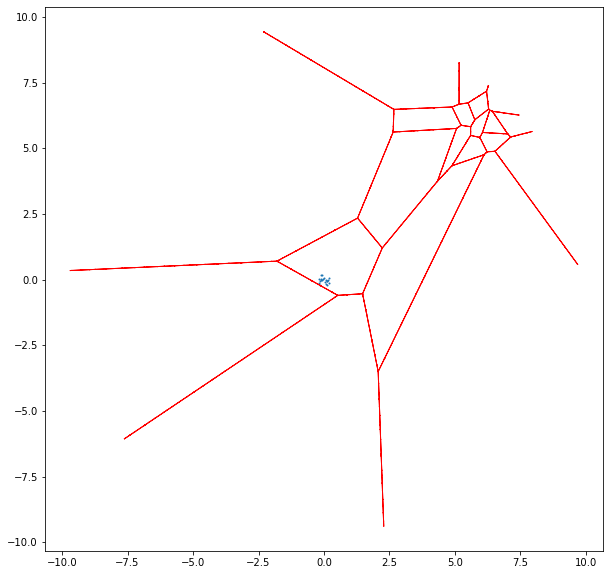

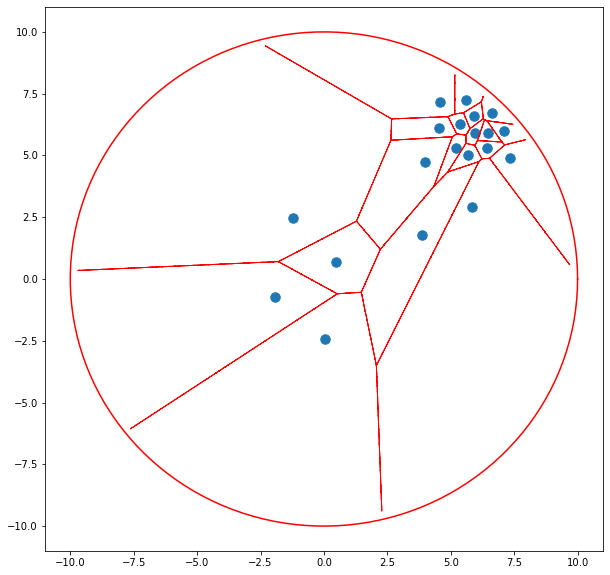

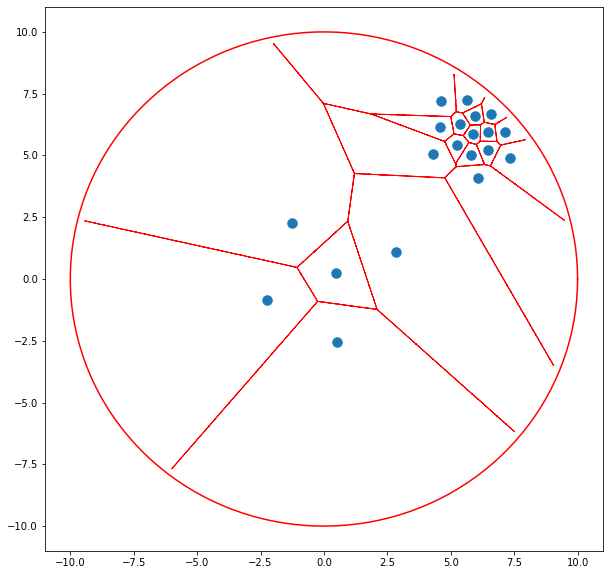

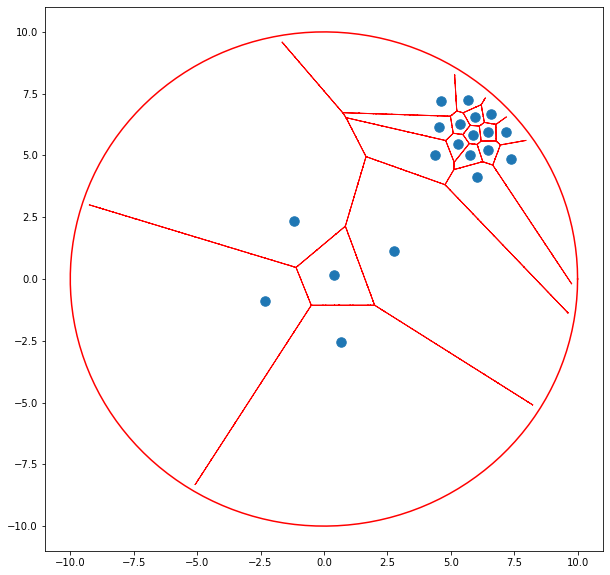

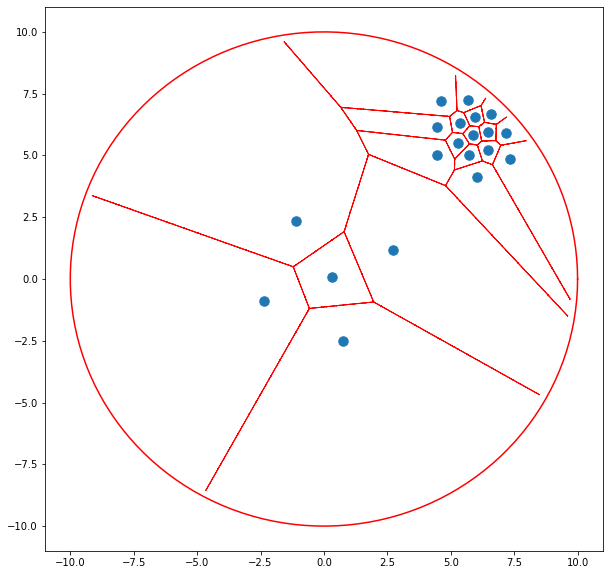

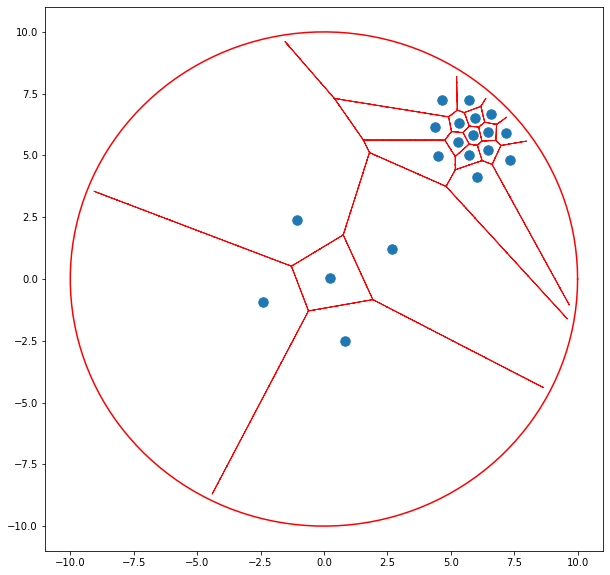

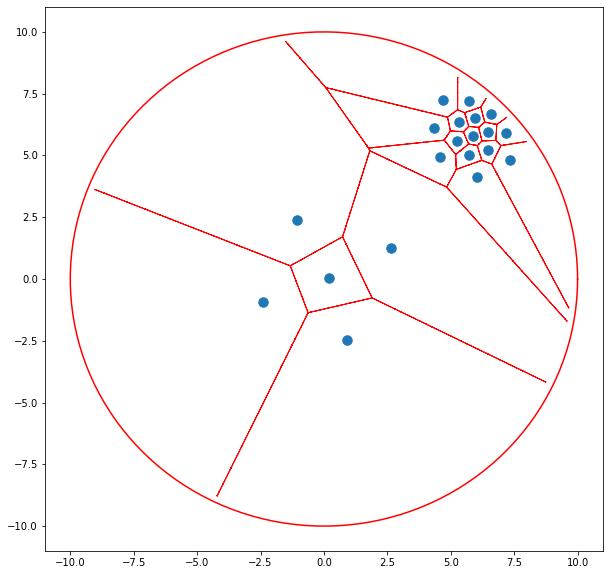

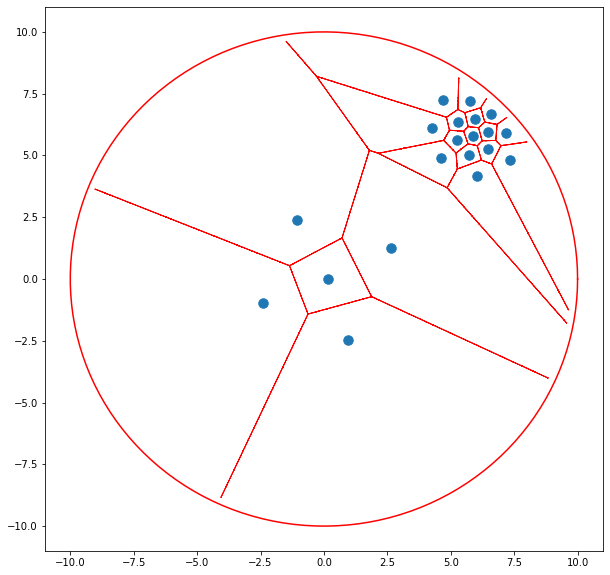

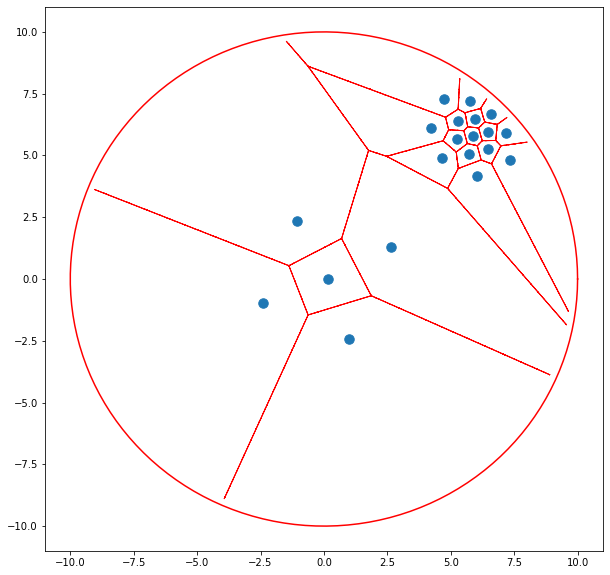

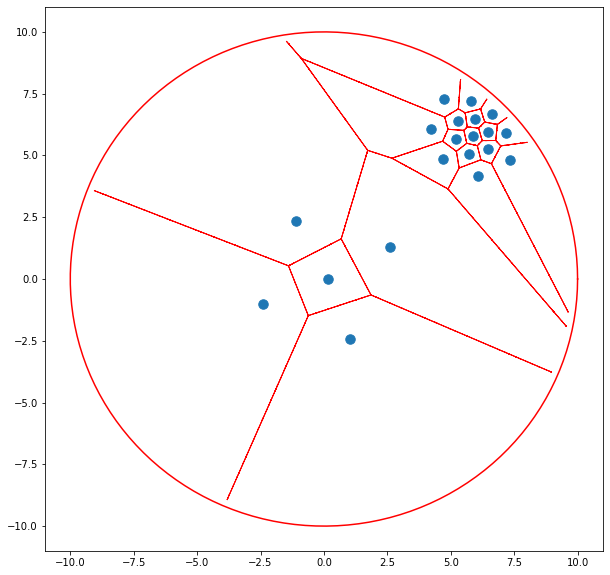

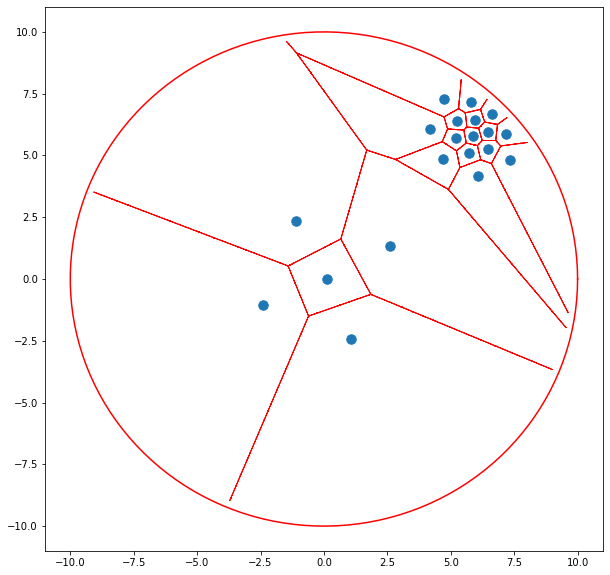

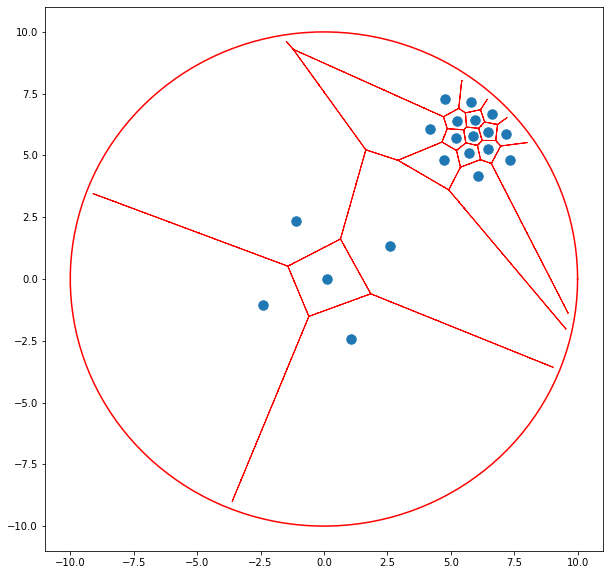

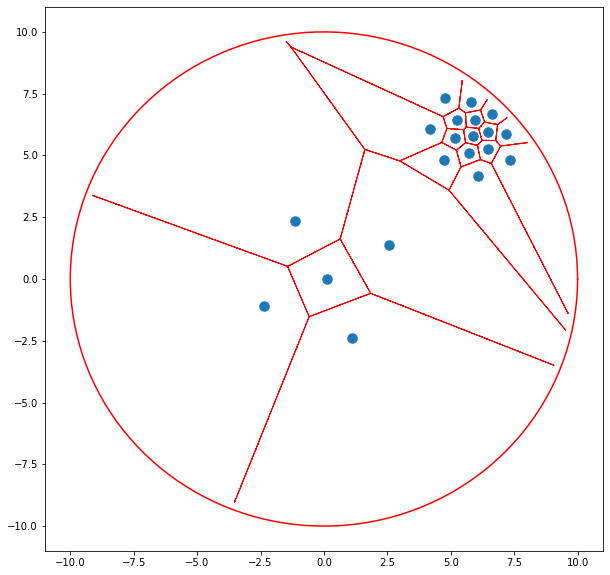

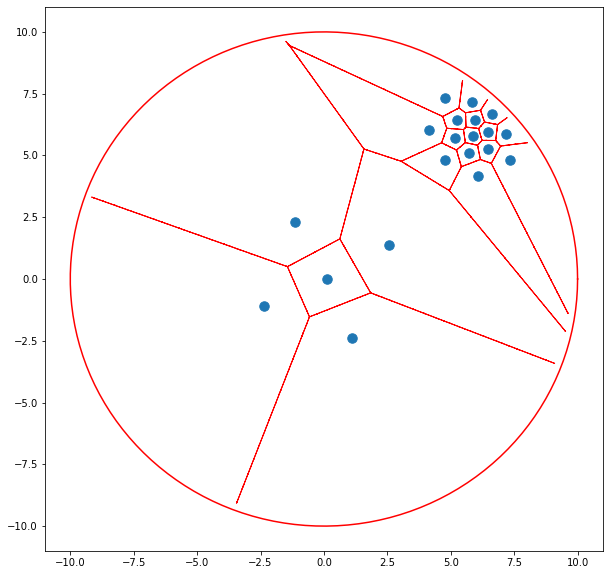

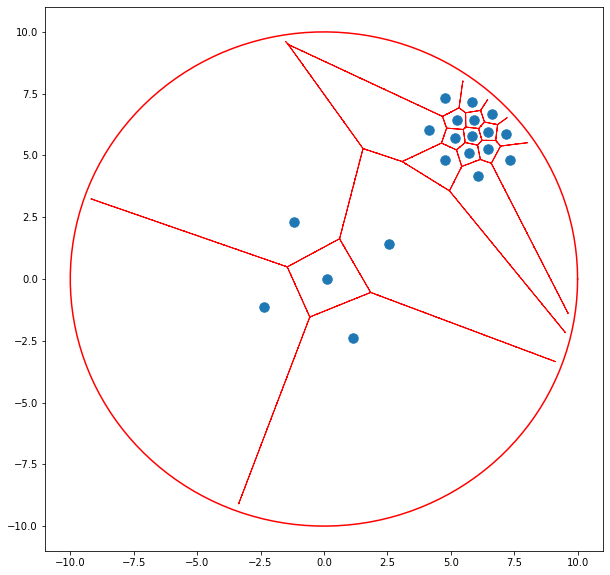

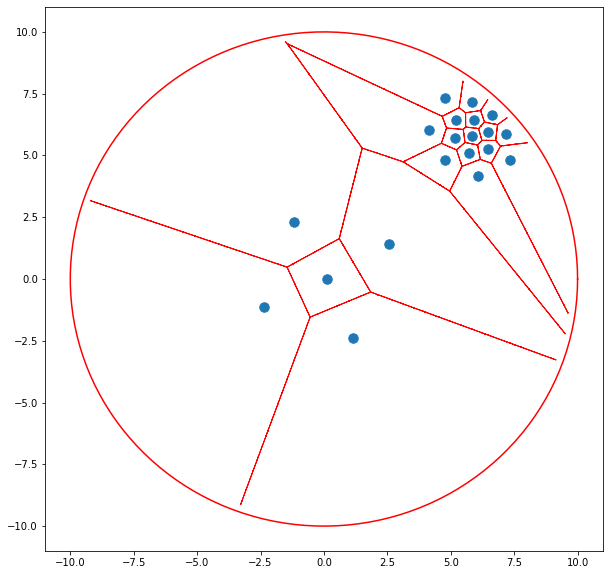

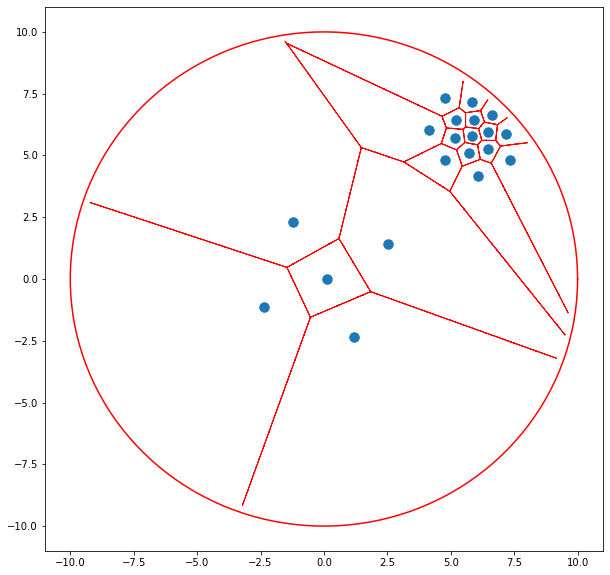

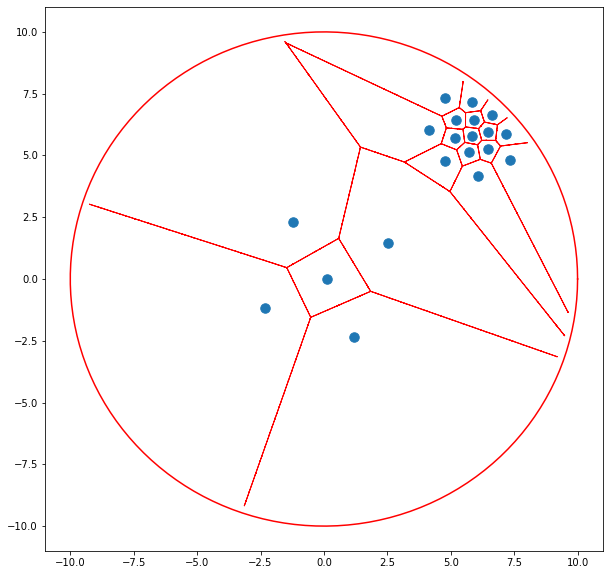

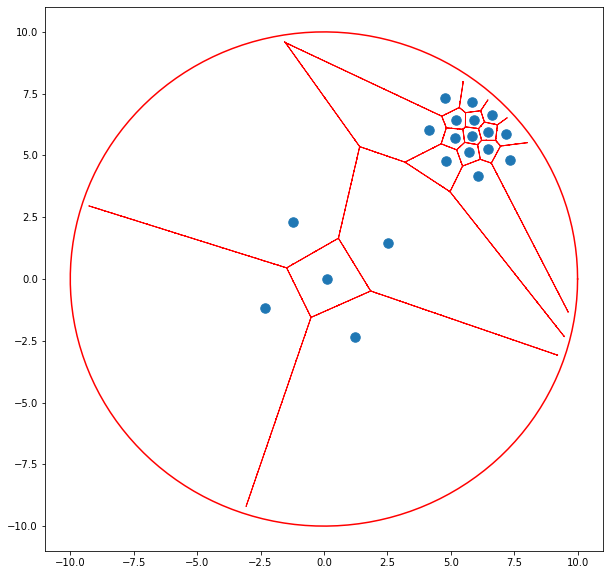

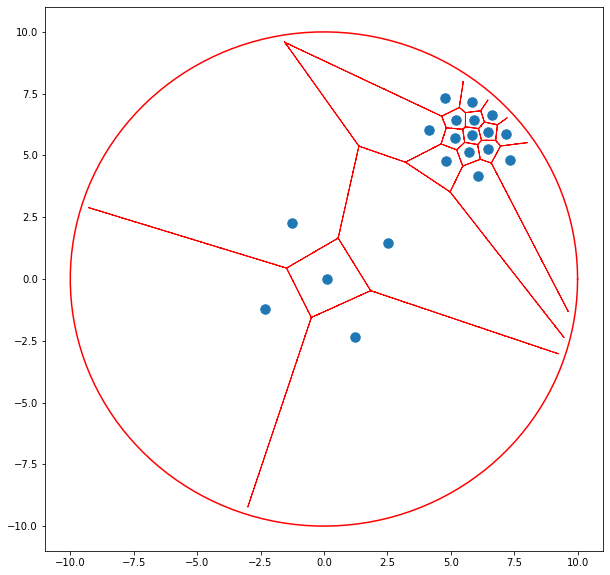

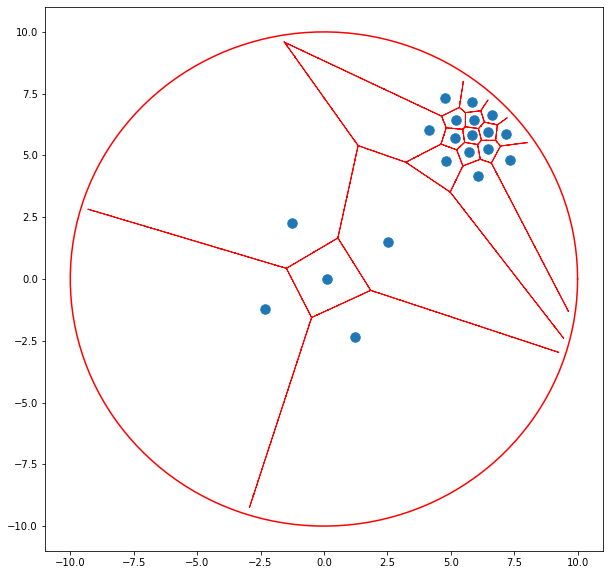

In [9]:
X=Gaussian_mixture_2([1/8,7/8],[[0,0],[6,6]],[4,1],10)
dens=ma.Density_2(X[0],X[1])
N =20;
Graph=np.zeros((N,2))
Y=np.zeros((N,2))

for k in range(N):
    Y[k][0]=np.random.uniform(-0.2,0.2)
    Y[k][1]=np.random.uniform(-0.2,0.2)
Y_save=Y

plt.figure(figsize=(10,10),facecolor="white")



[Y2,F2,Norm2,Grad2]=Lloyd_iter_draw_Laguerre(dens,Y,20,2.5)


<h3>Optimal quantization

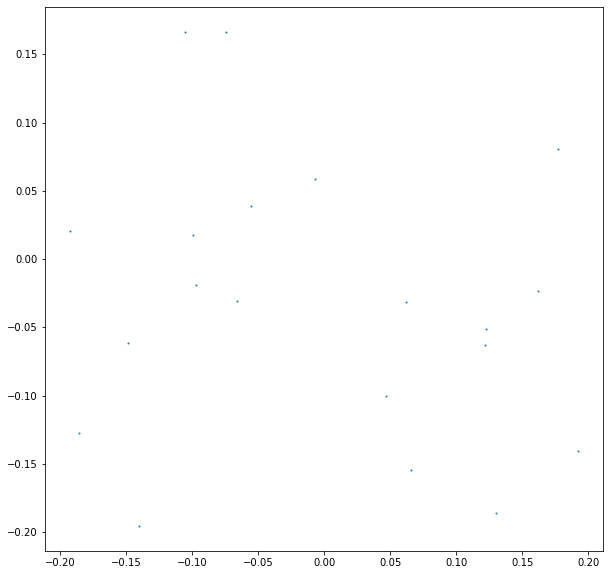

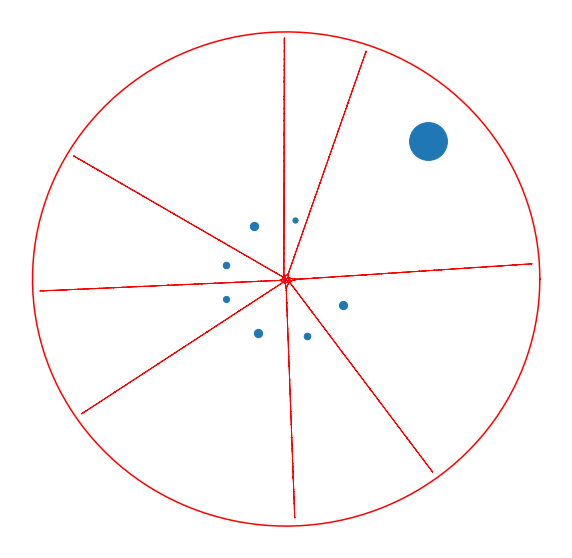

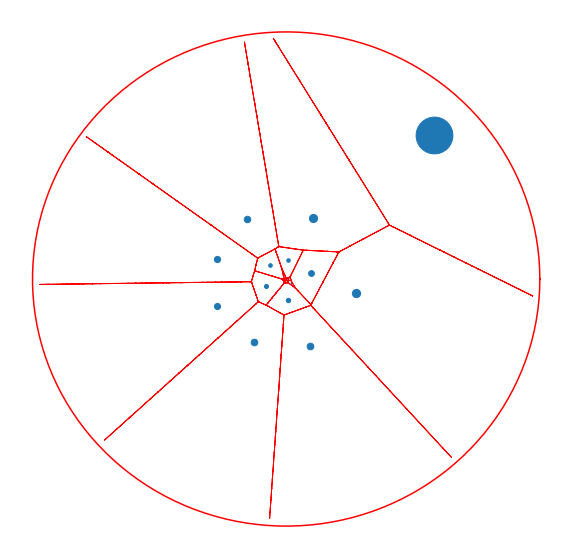

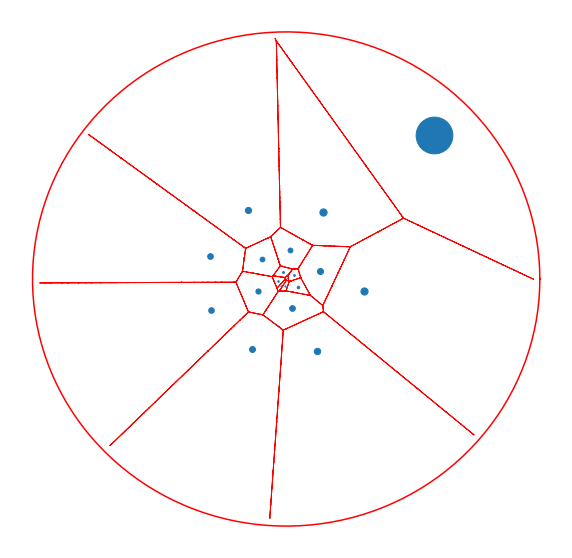

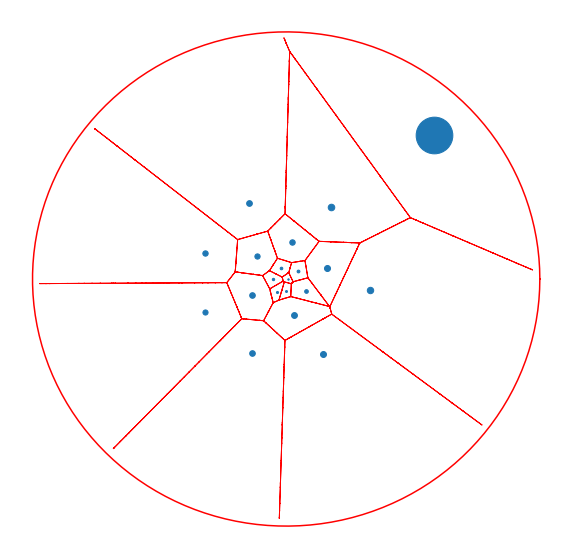

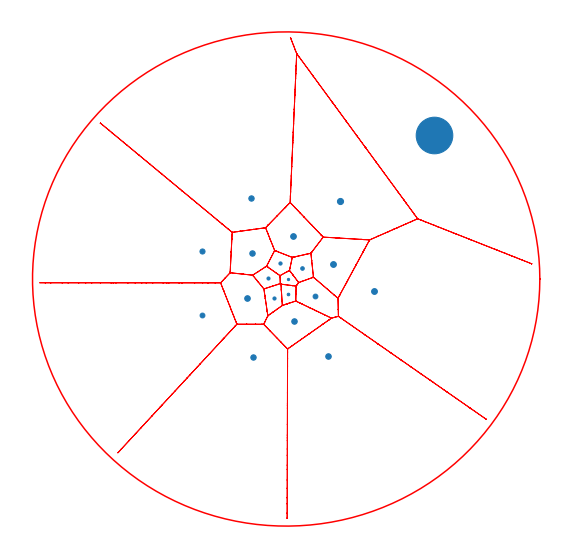

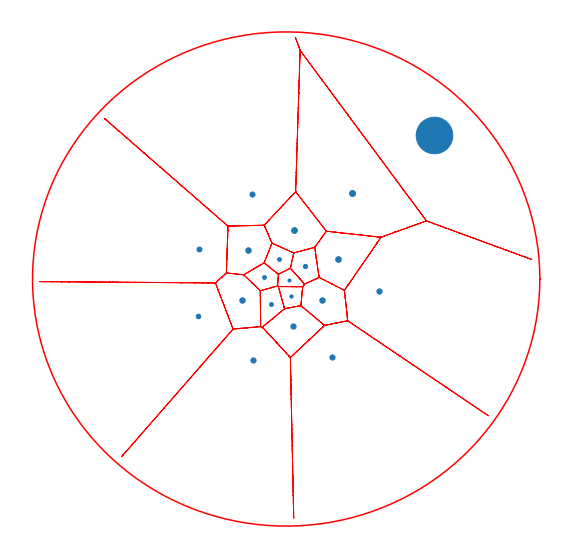

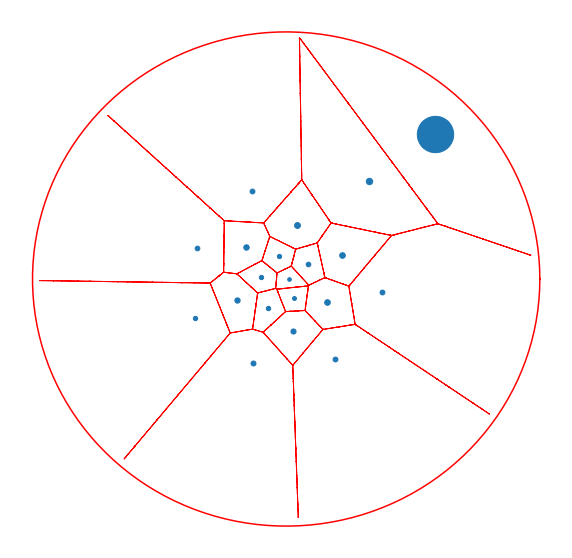

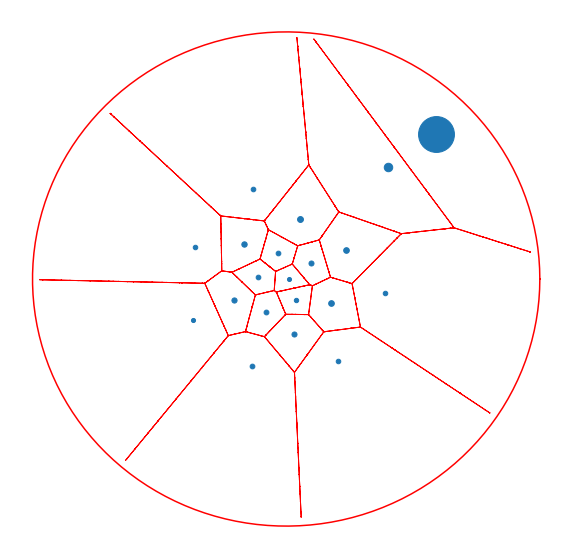

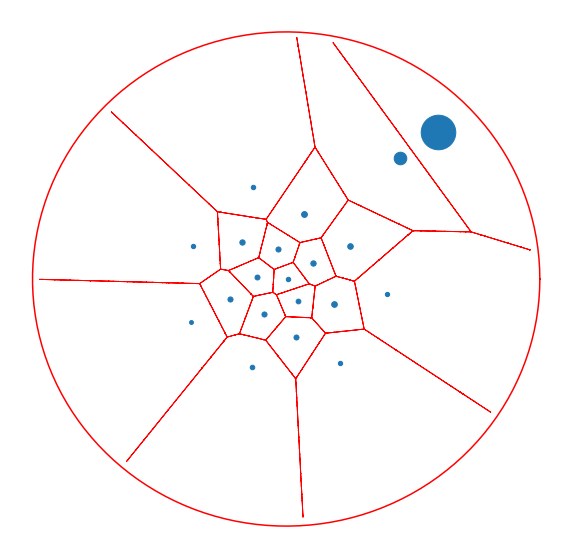

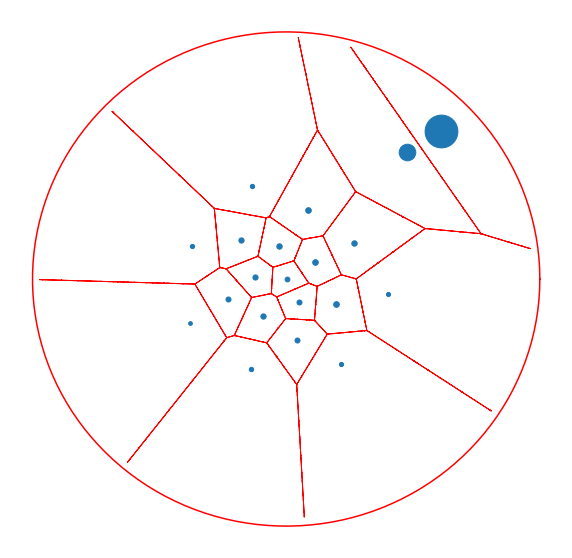

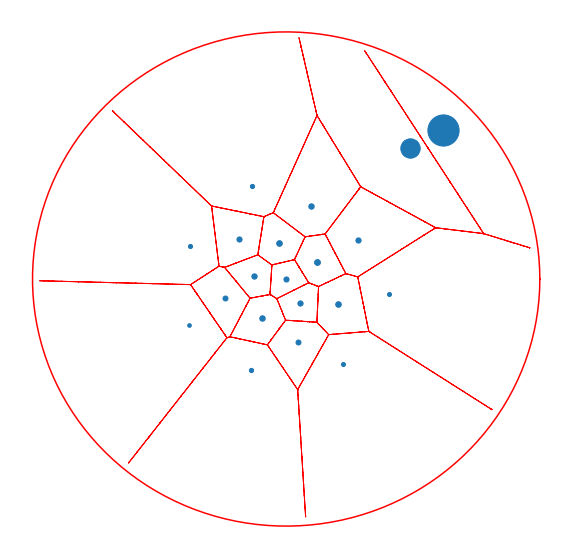

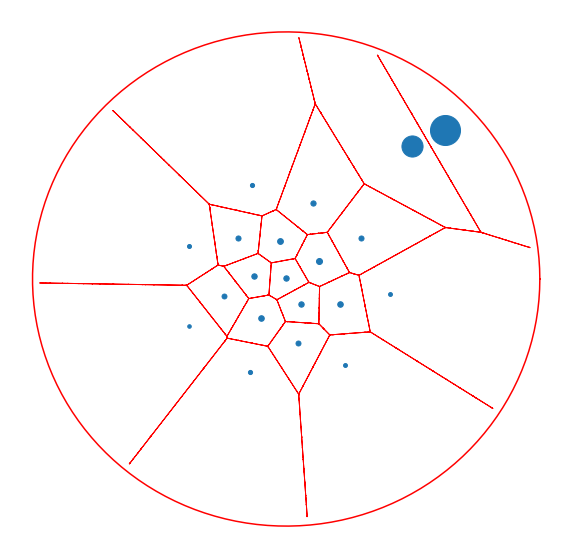

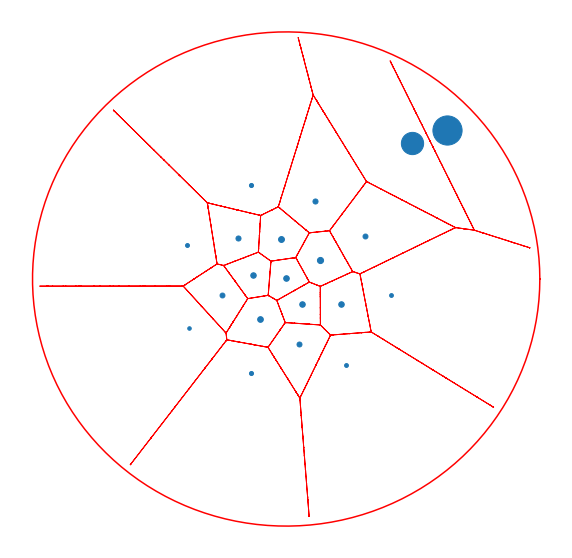

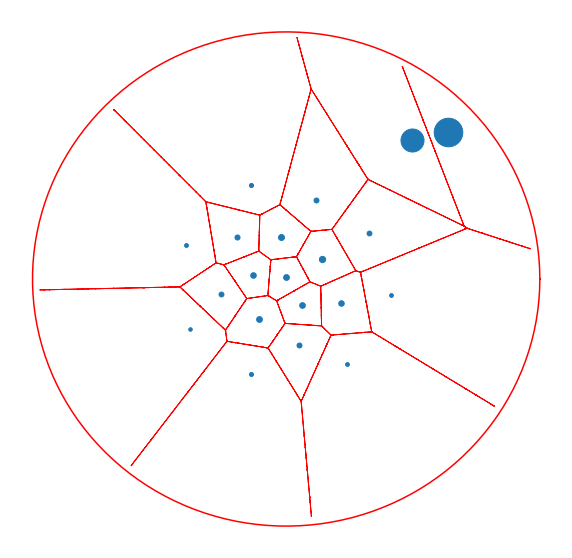

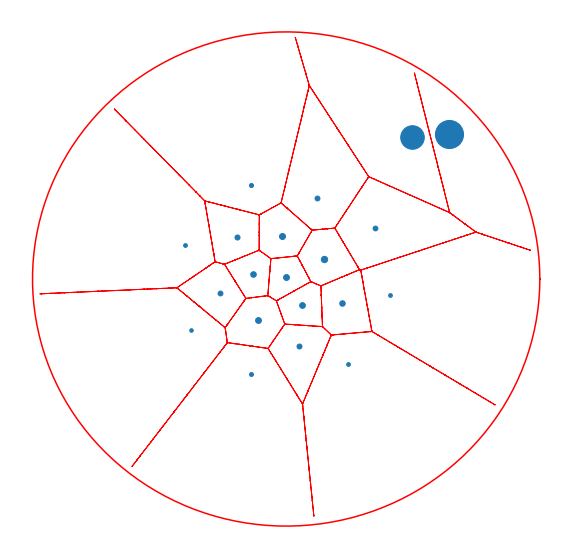

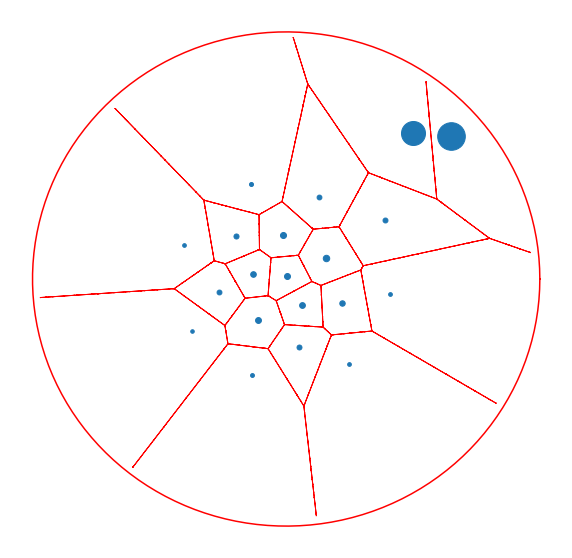

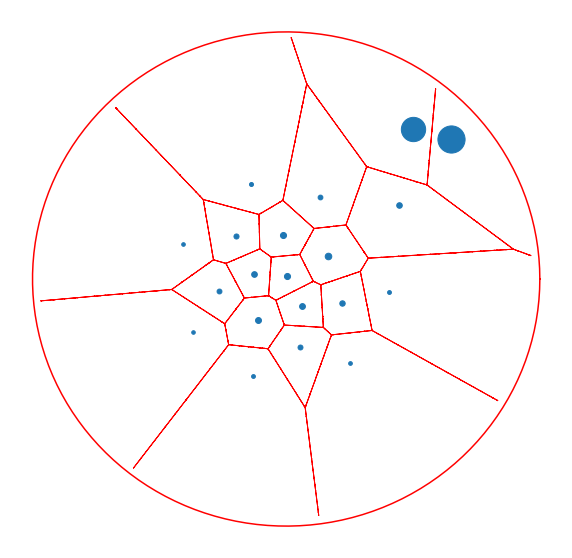

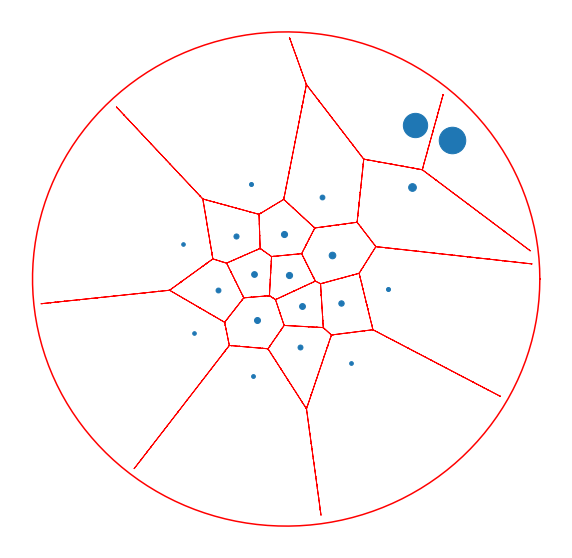

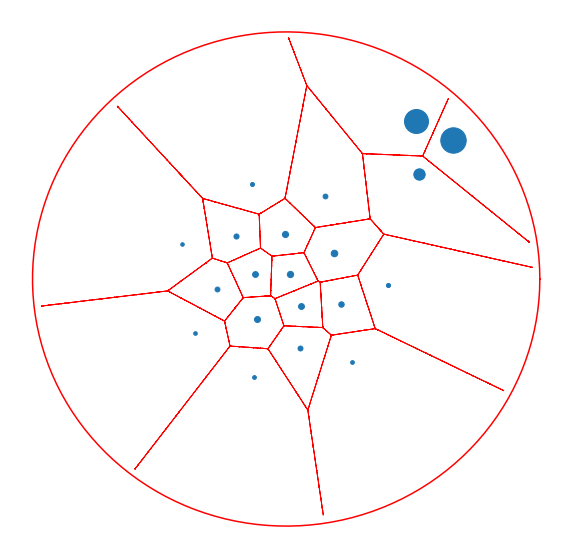

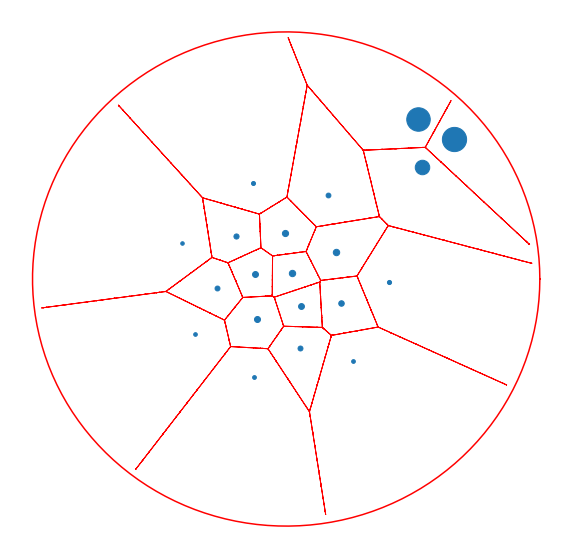

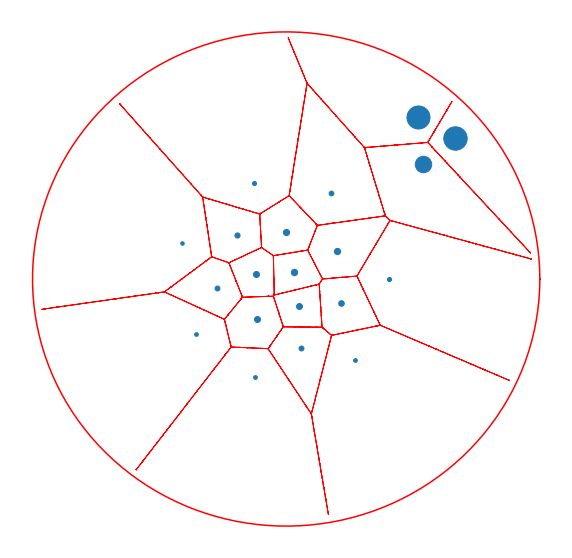

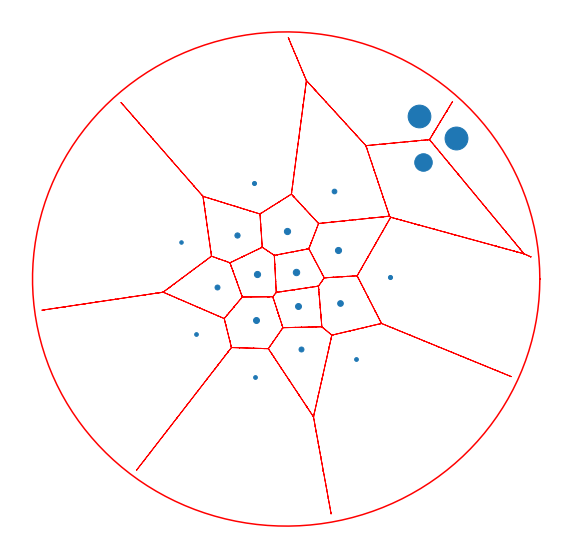

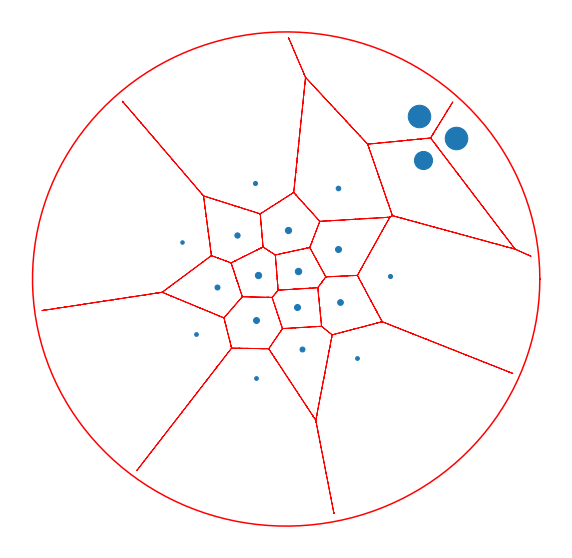

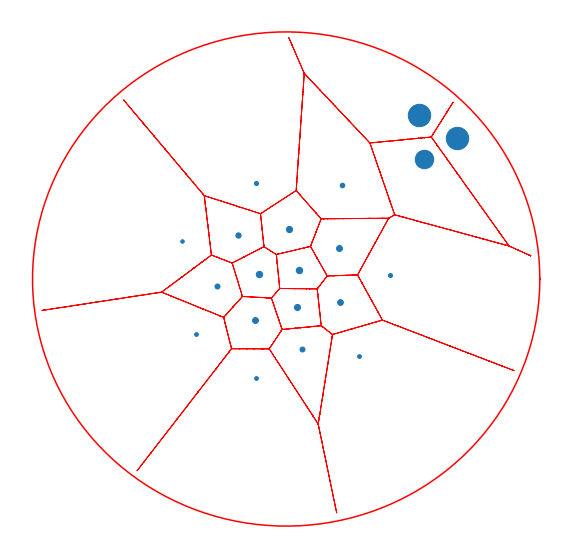

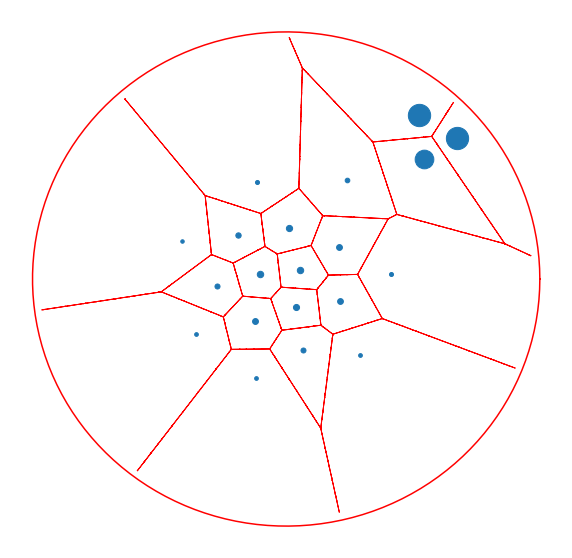

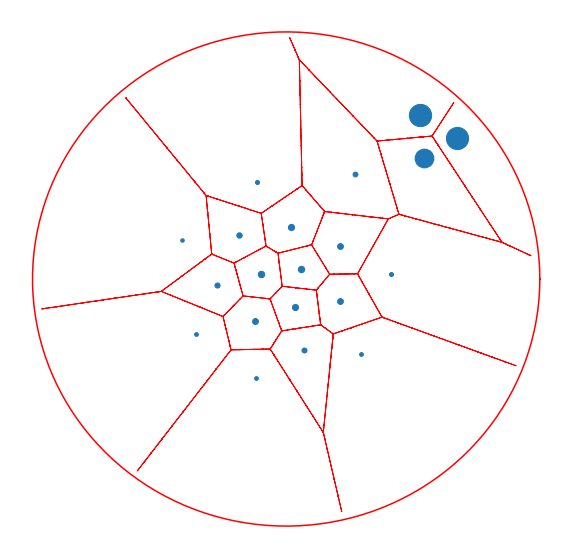

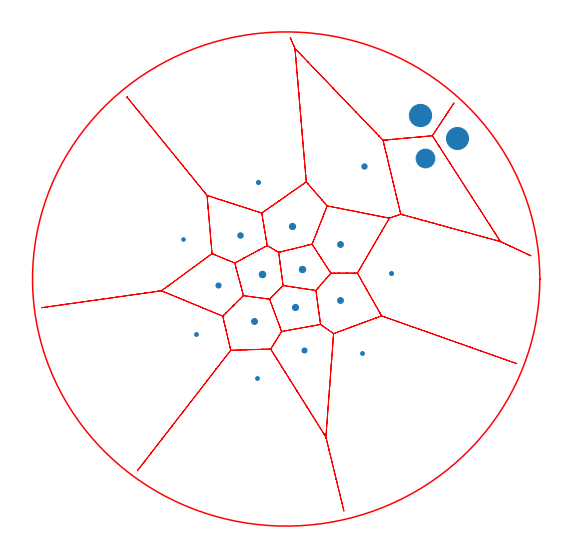

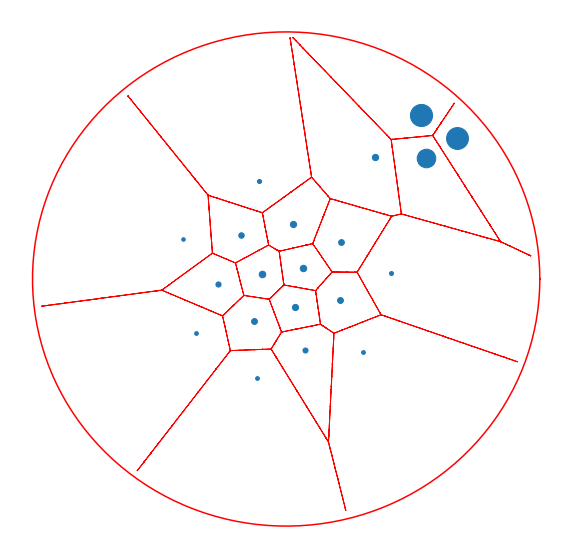

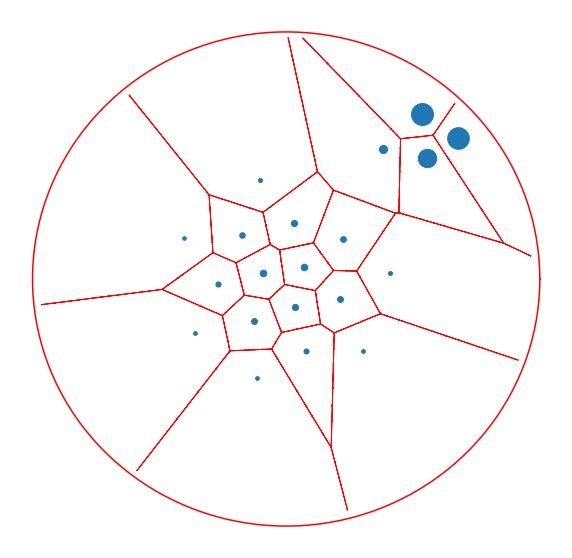

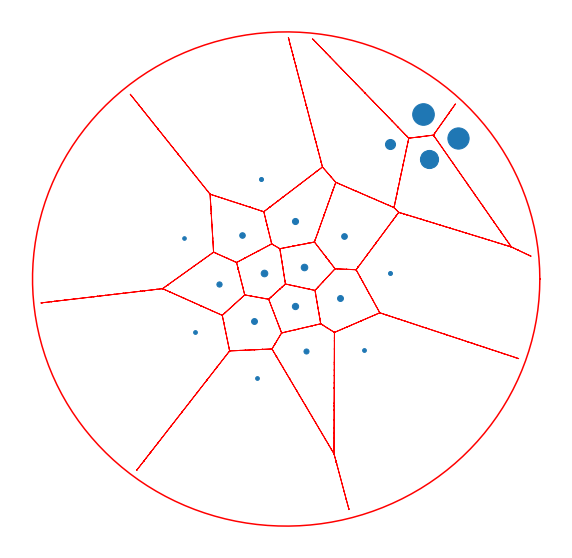

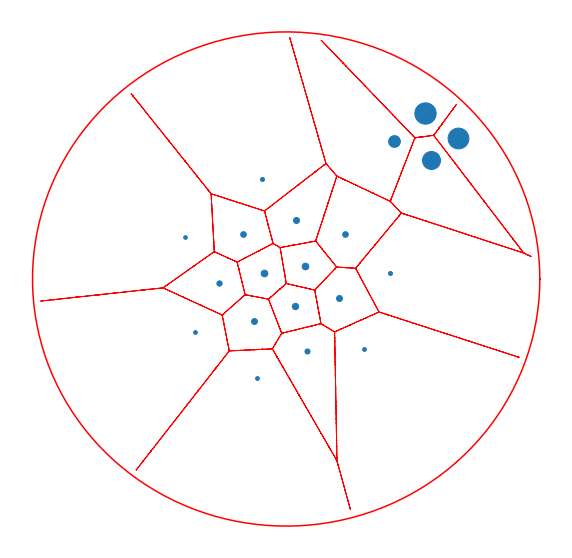

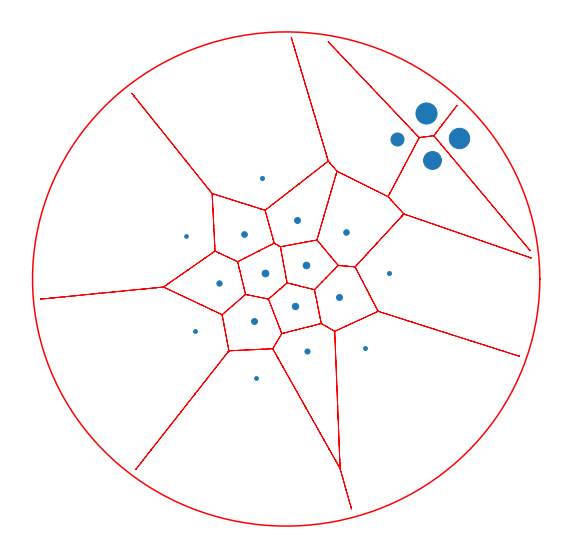

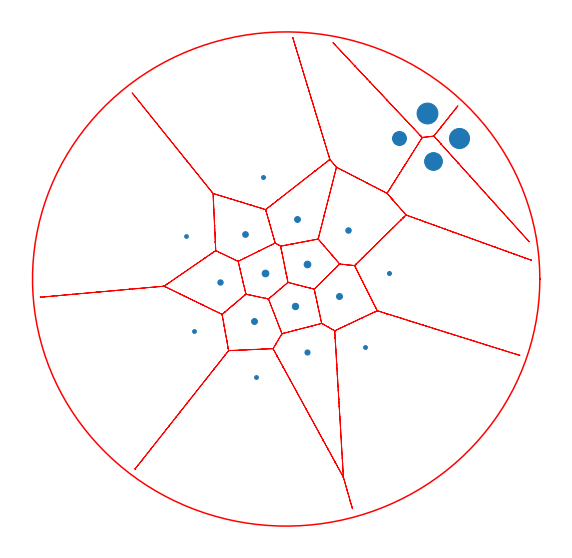

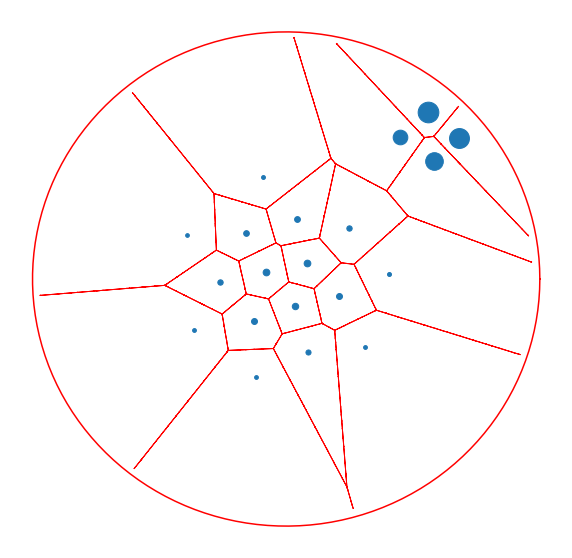

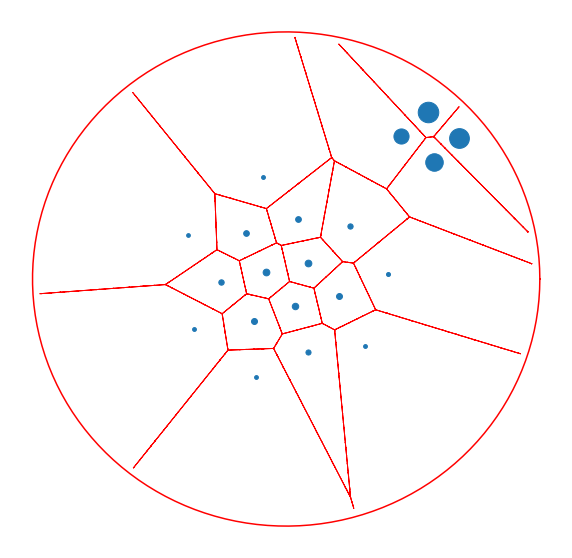

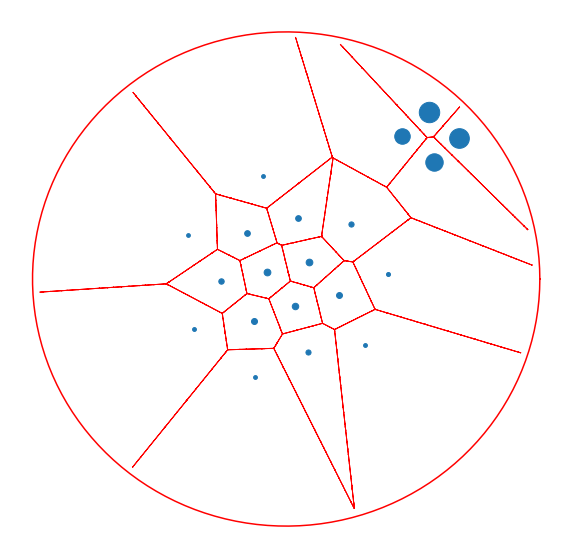

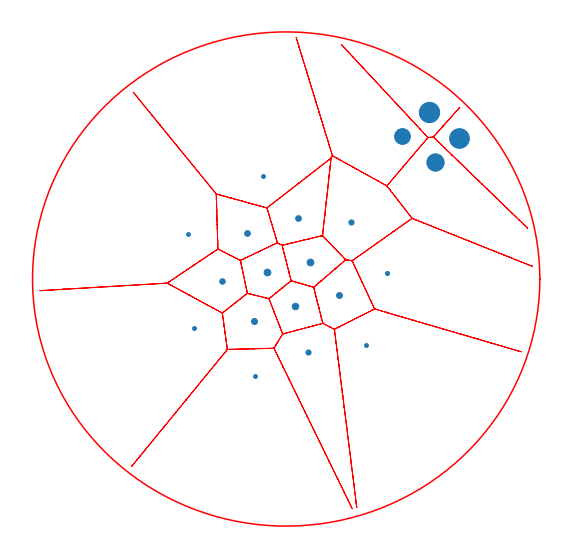

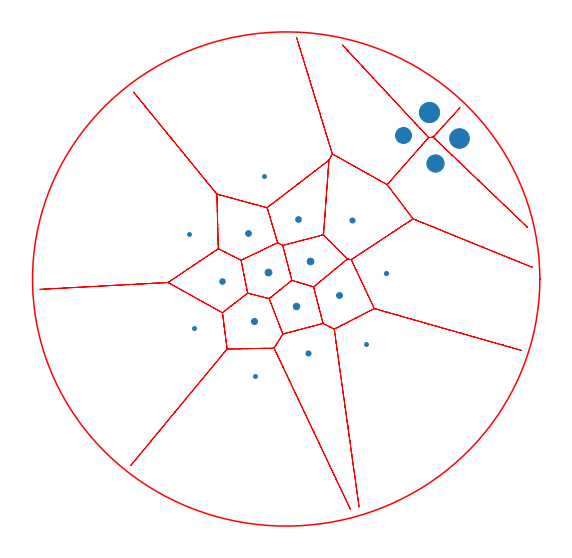

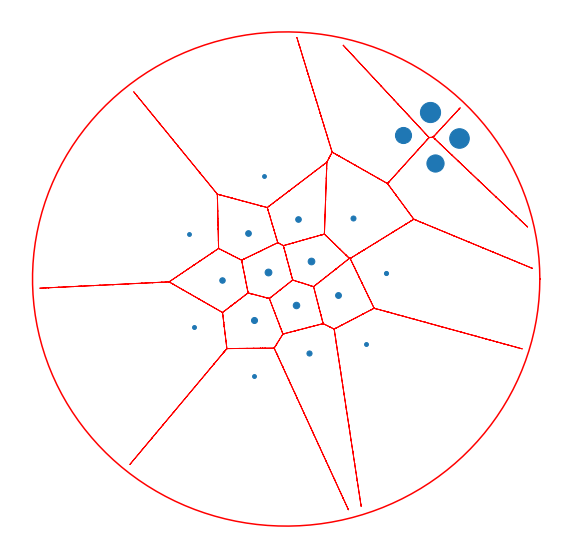

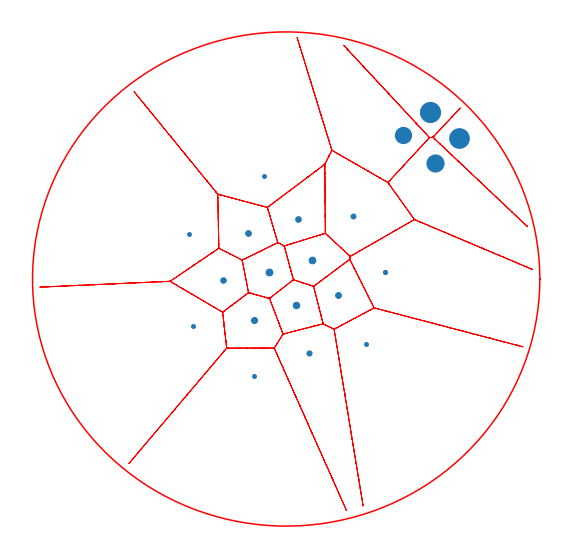

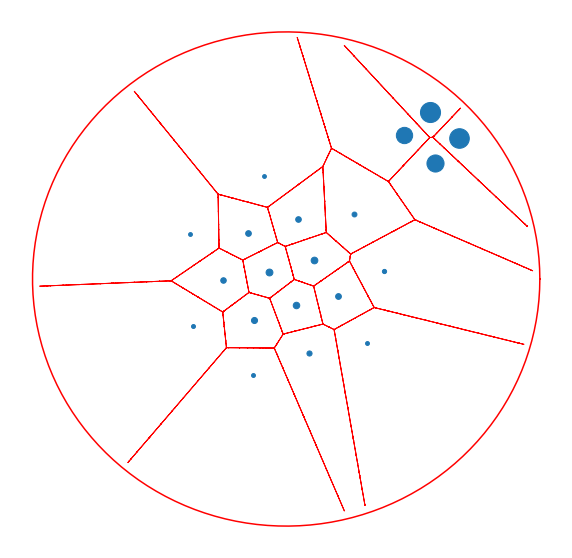

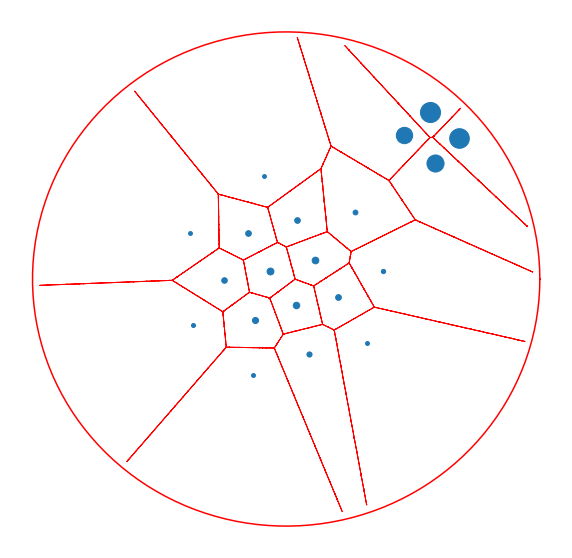

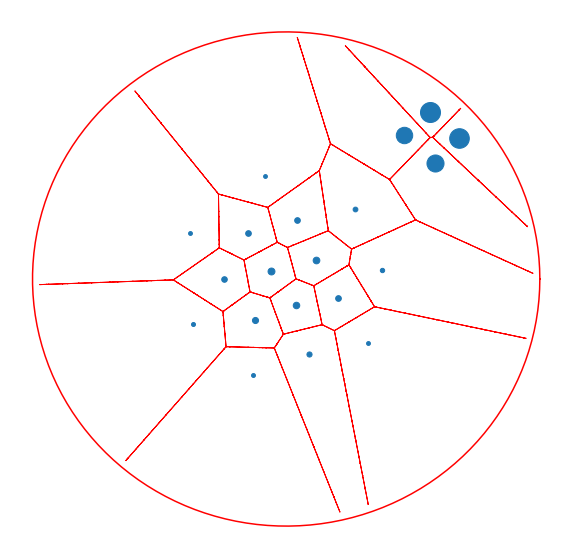

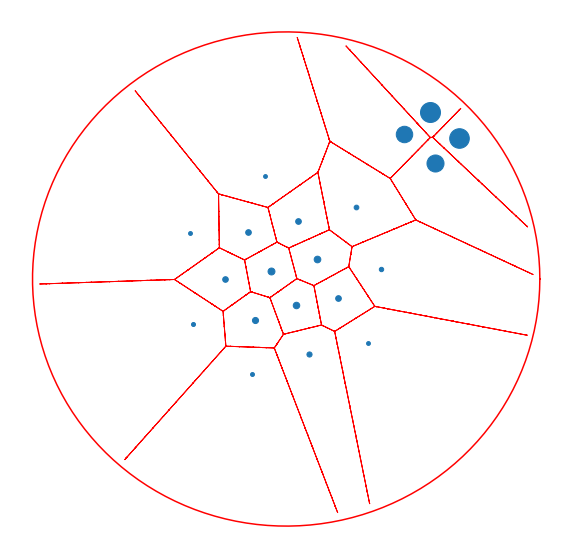

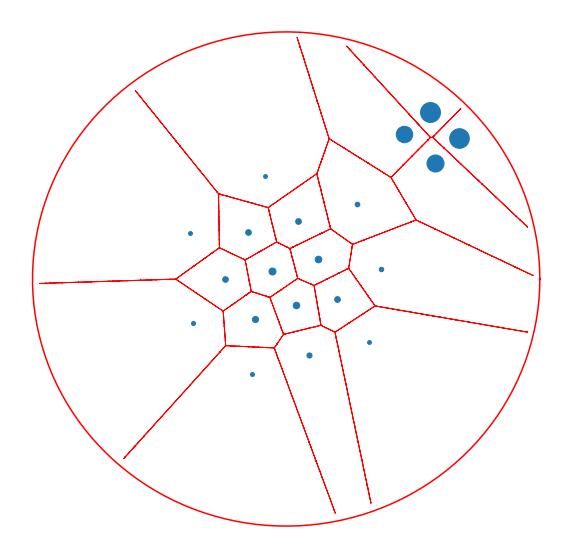

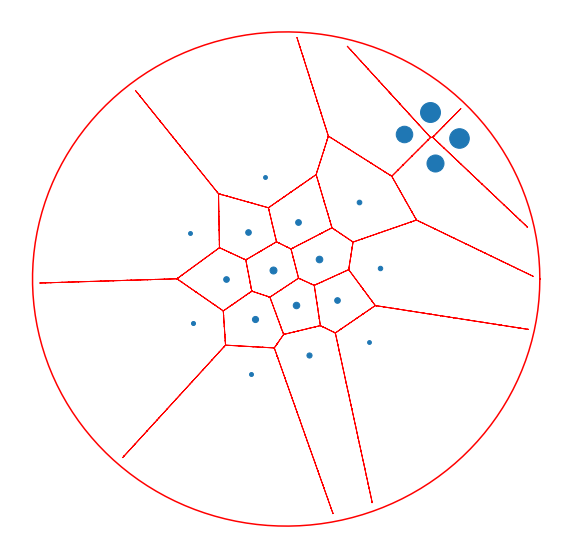

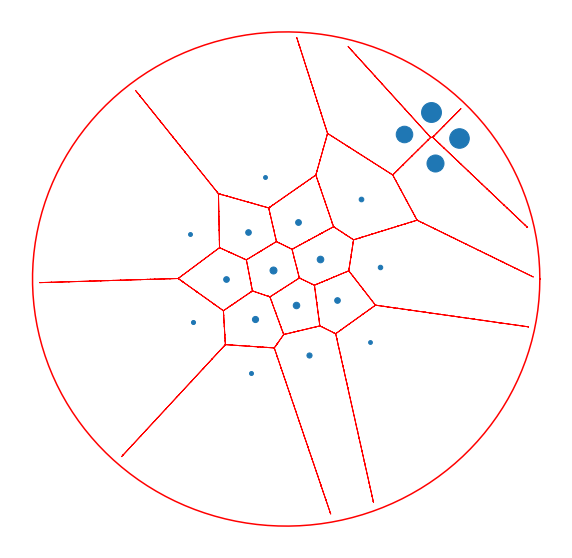

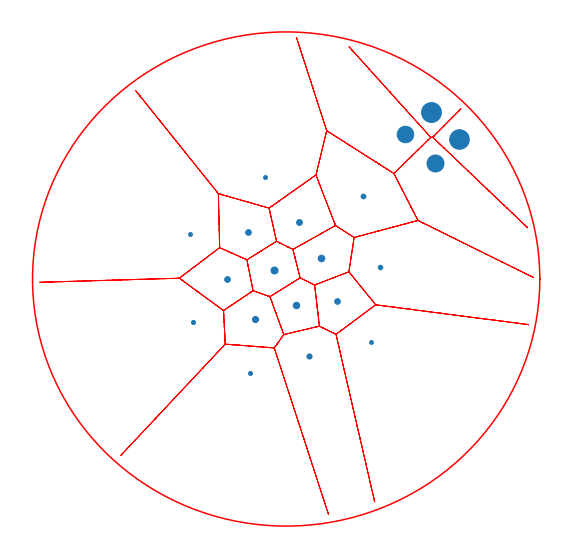

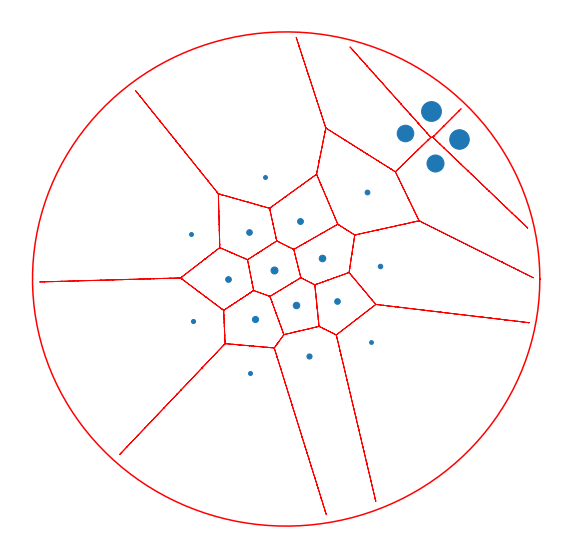

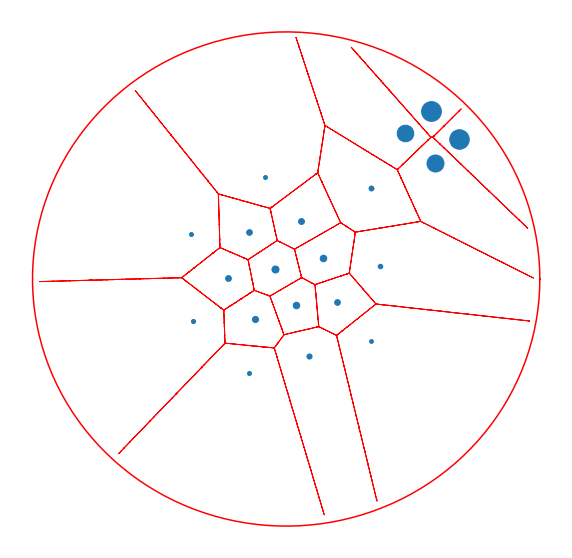

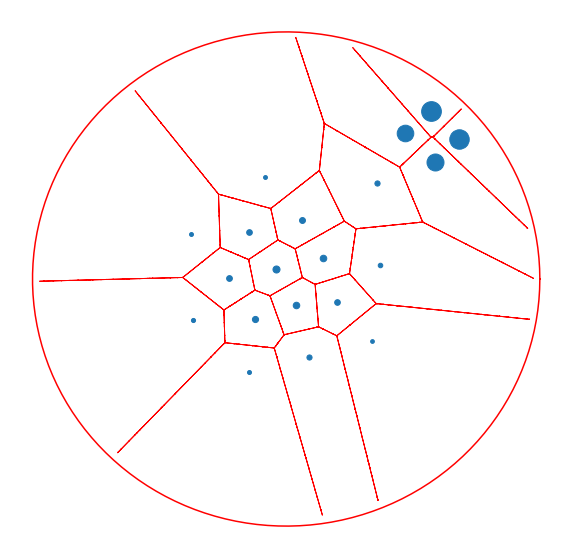

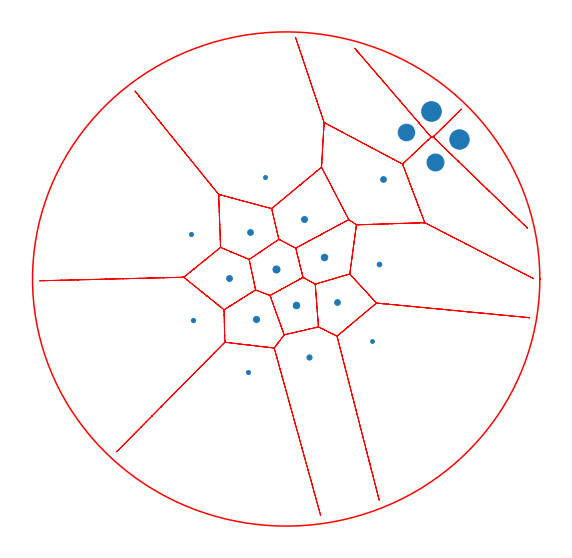

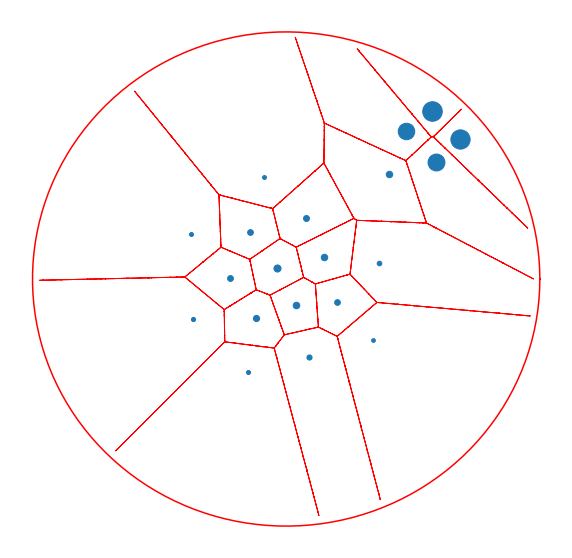

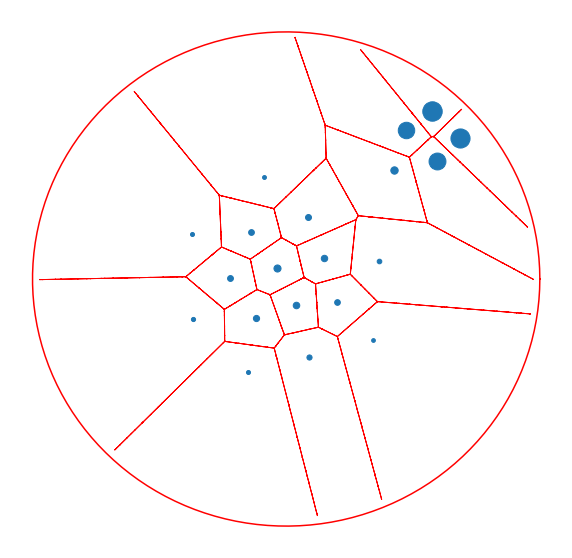

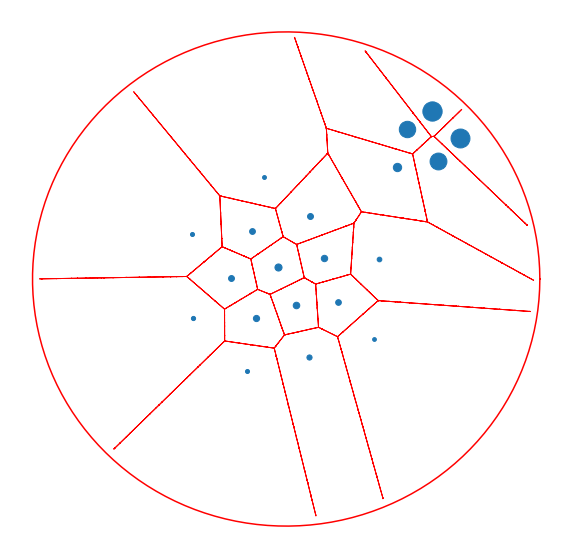

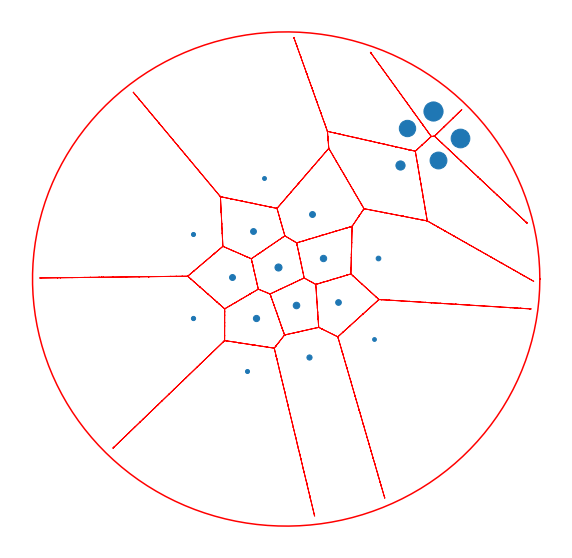

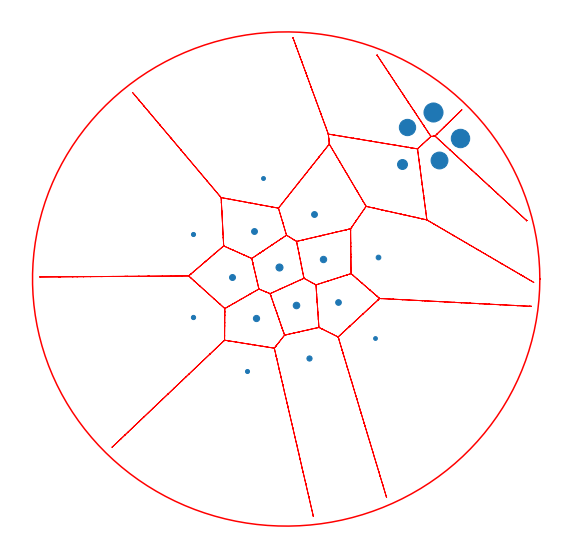

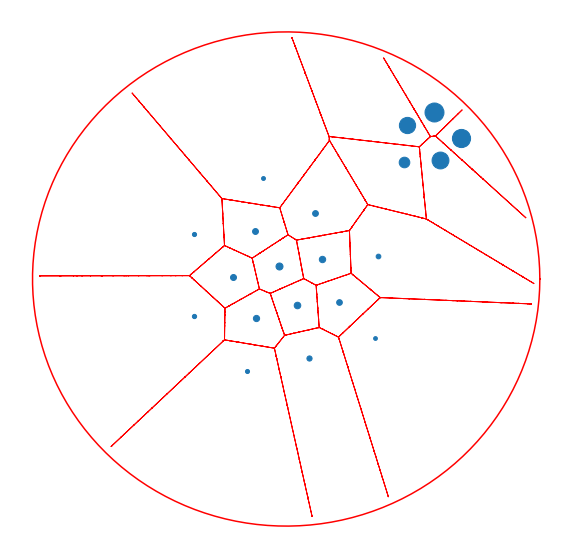

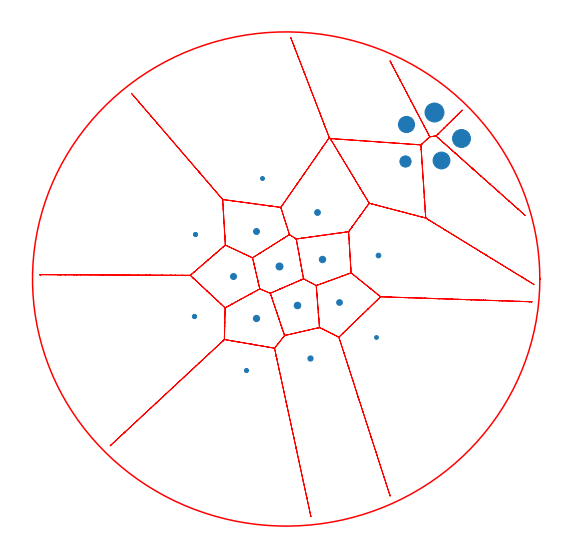

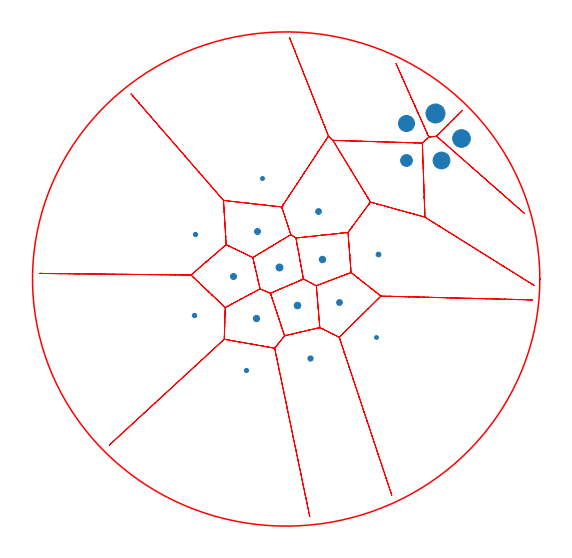

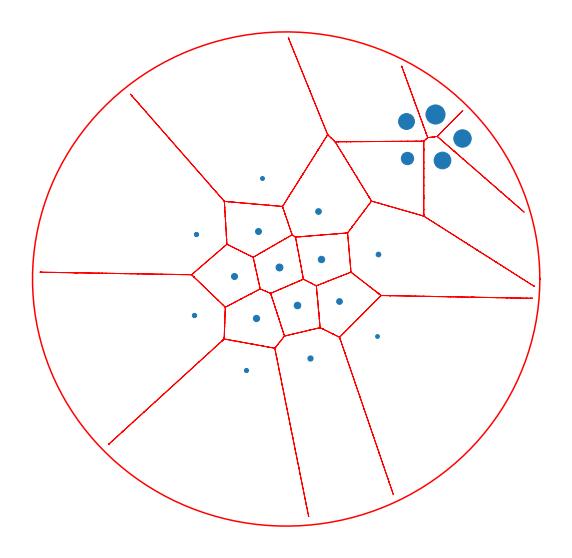

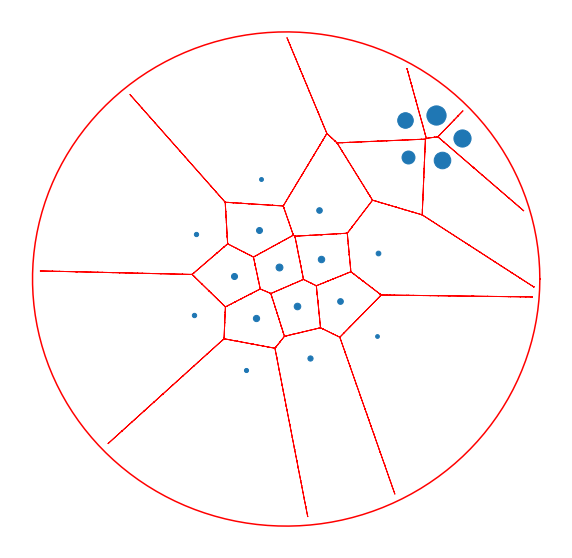

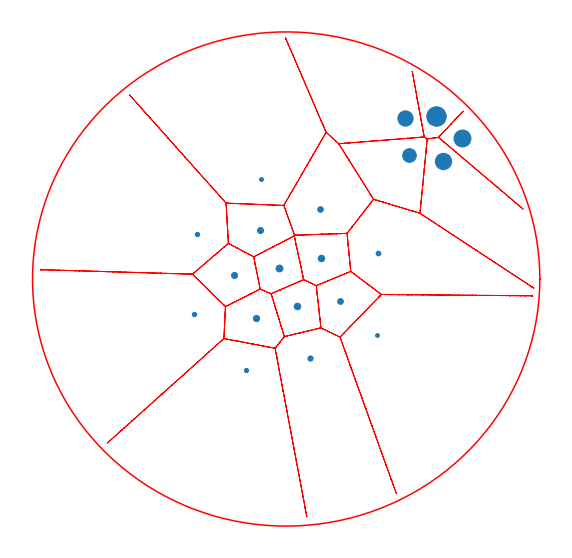

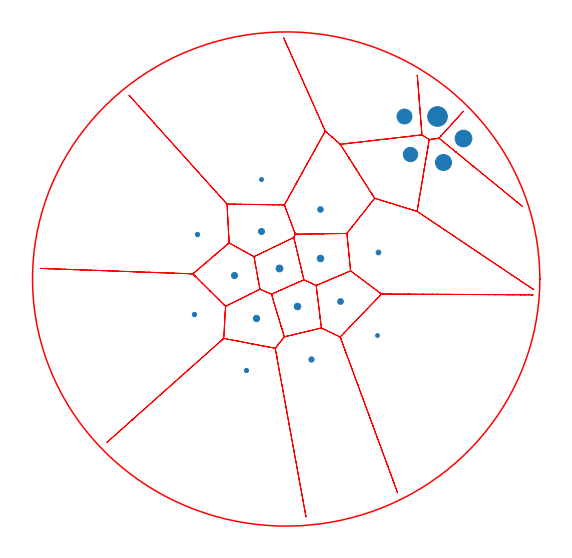

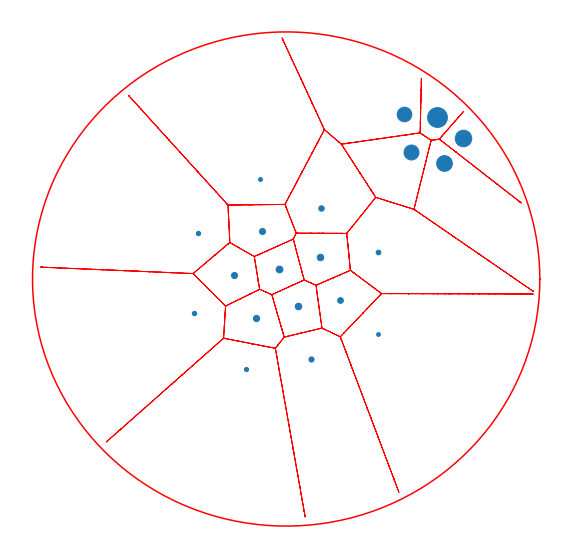

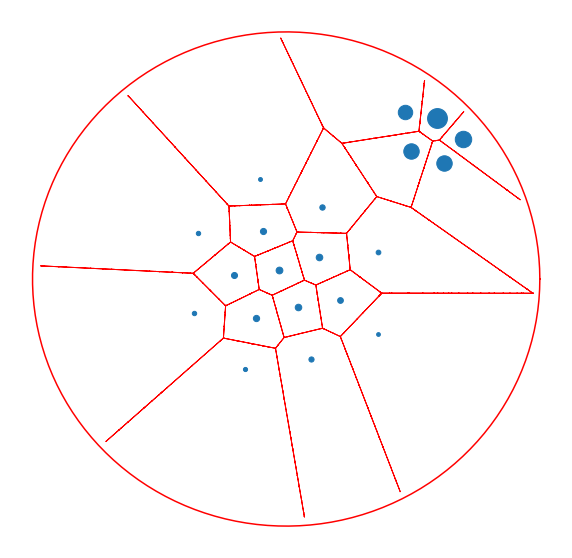

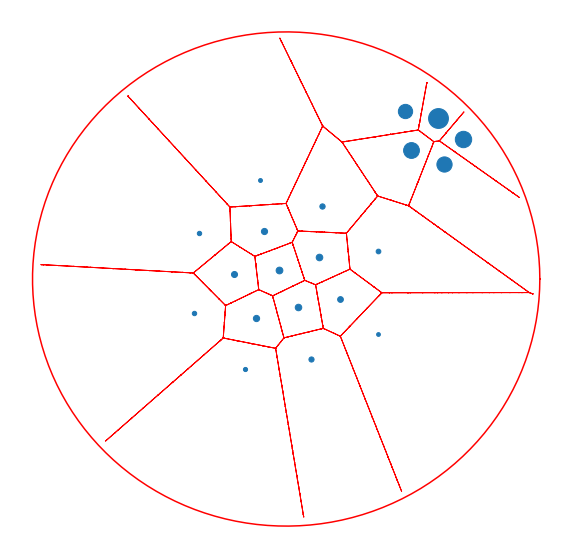

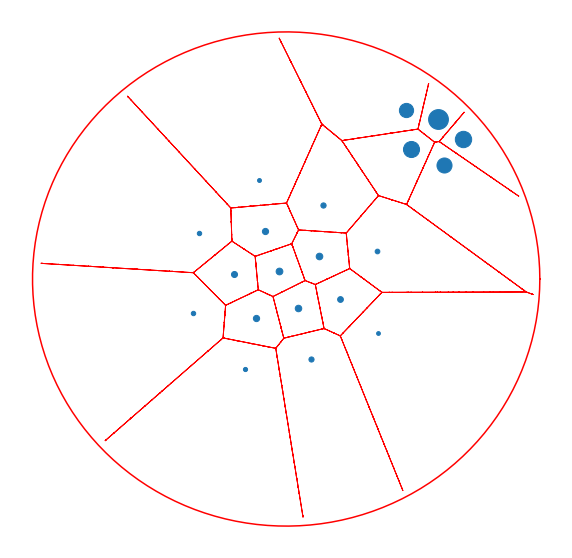

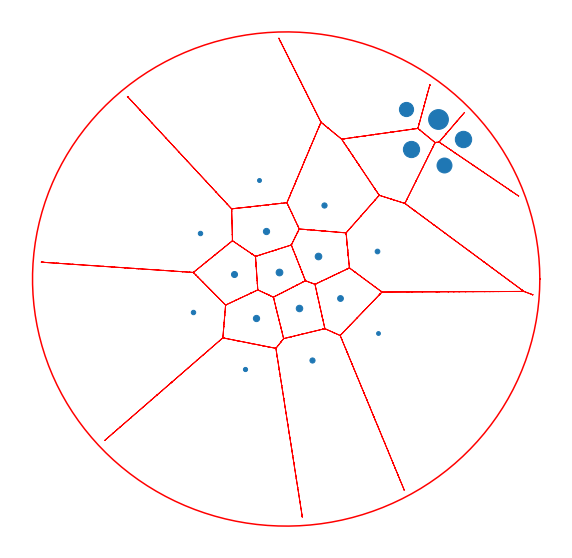

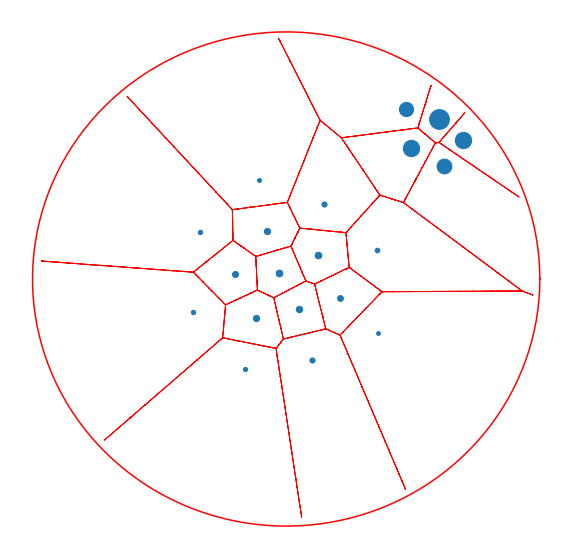

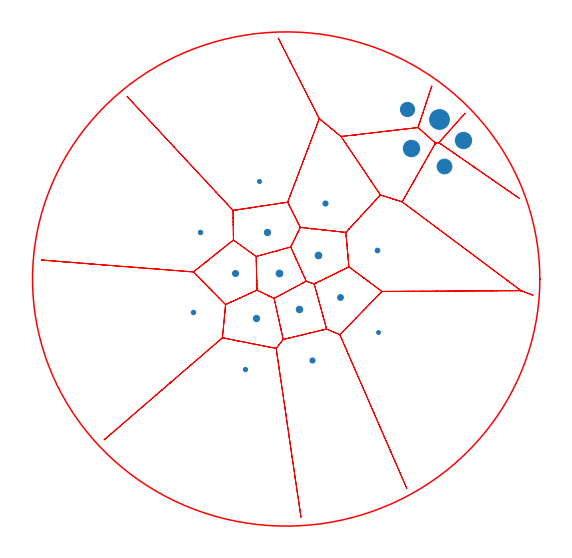

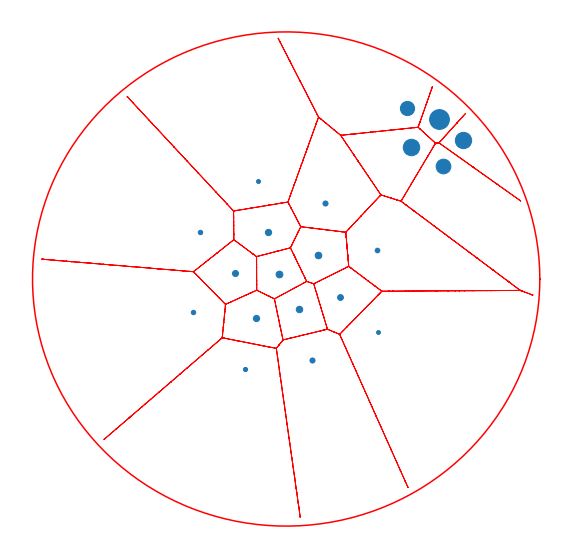

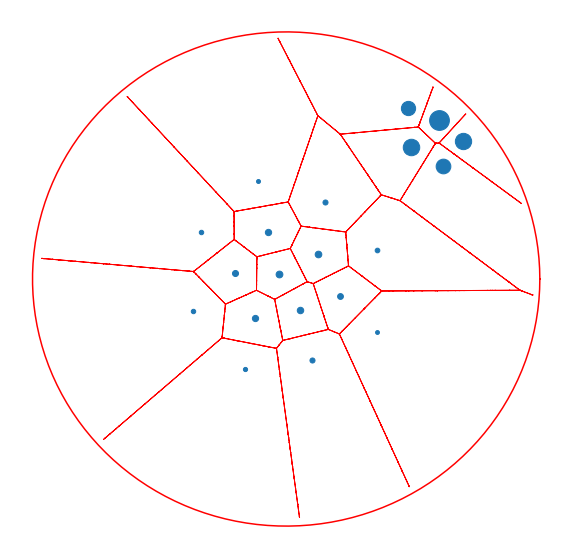

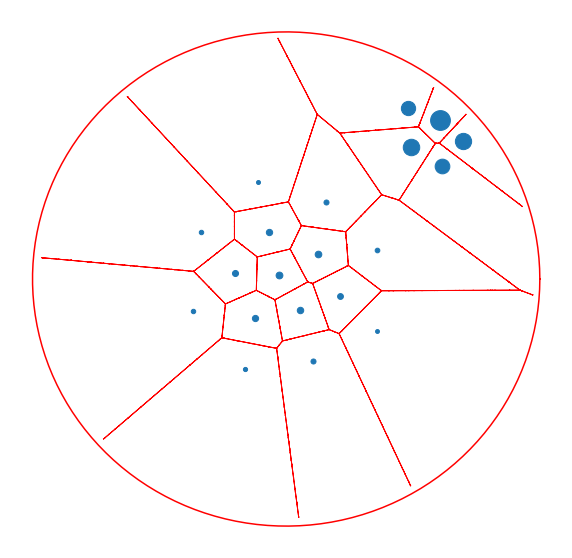

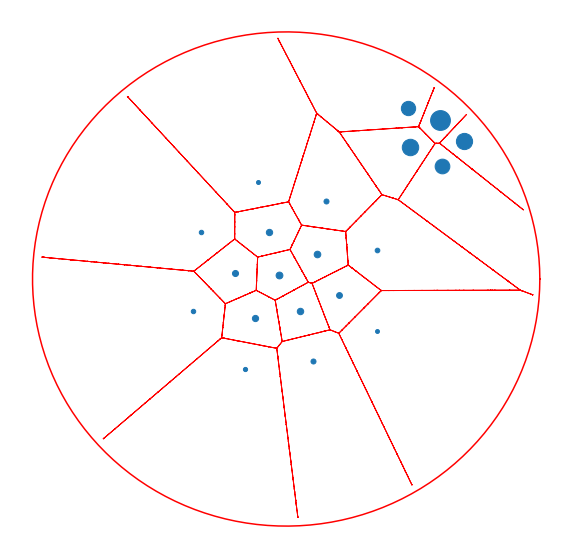

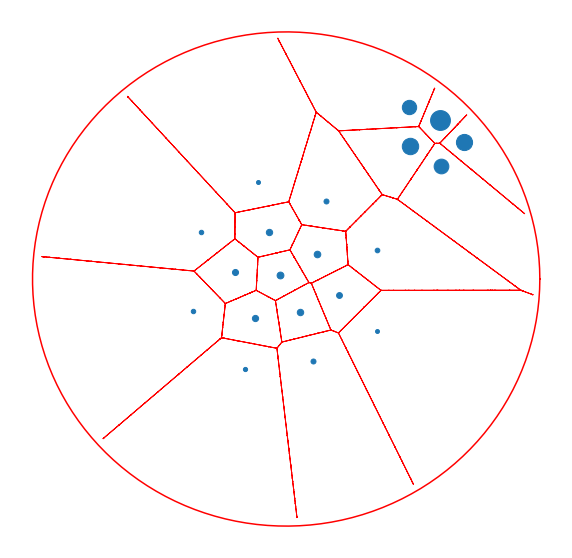

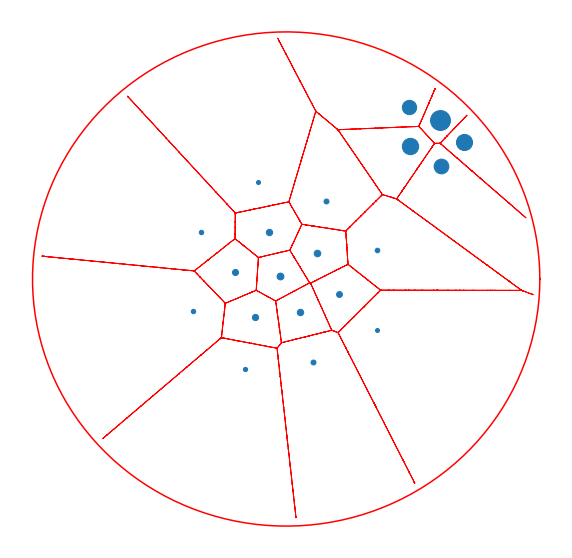

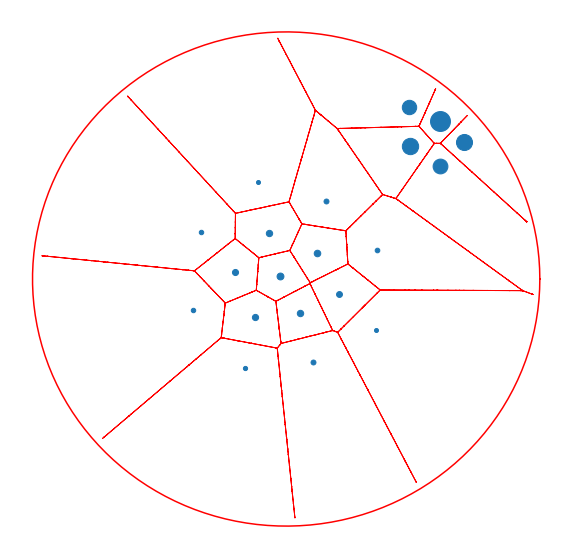

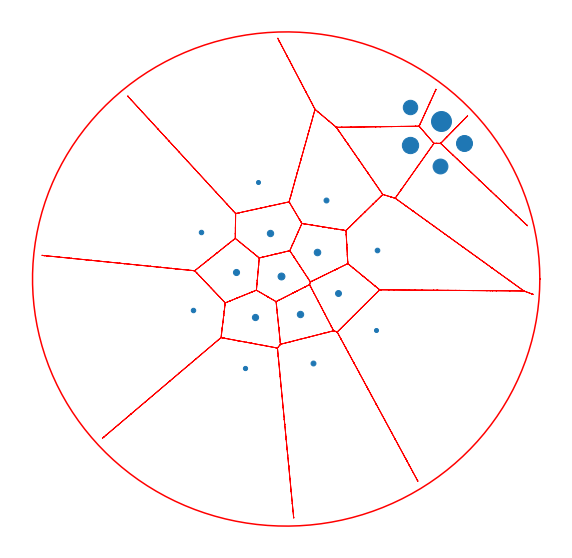

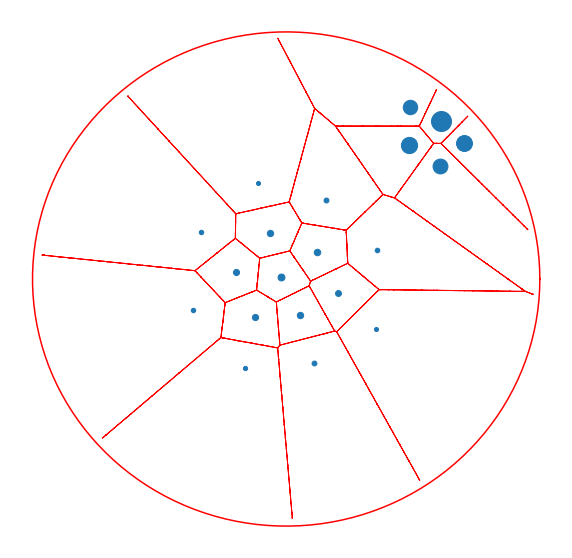

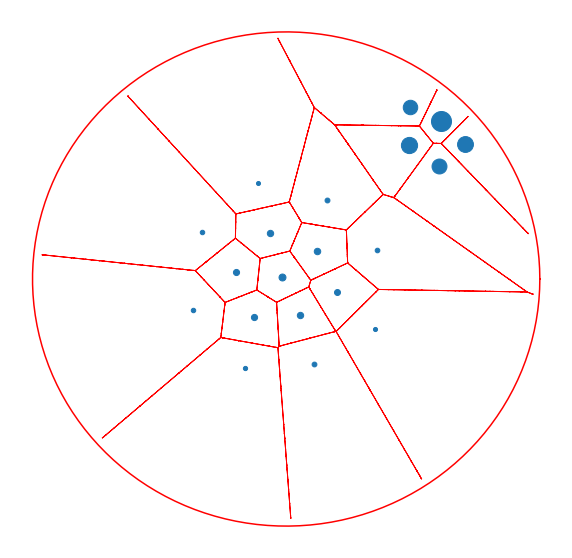

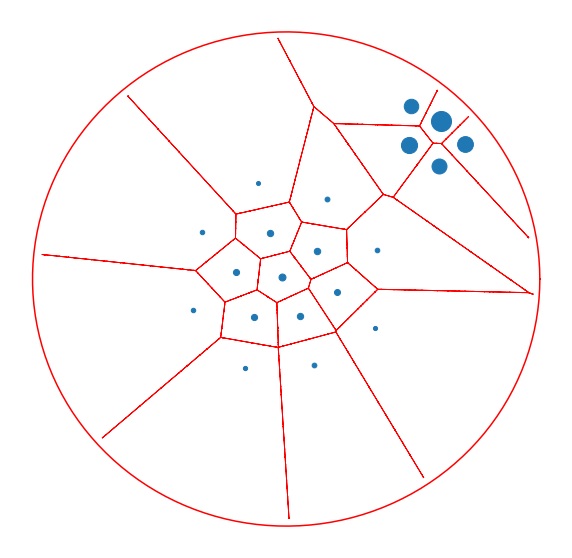

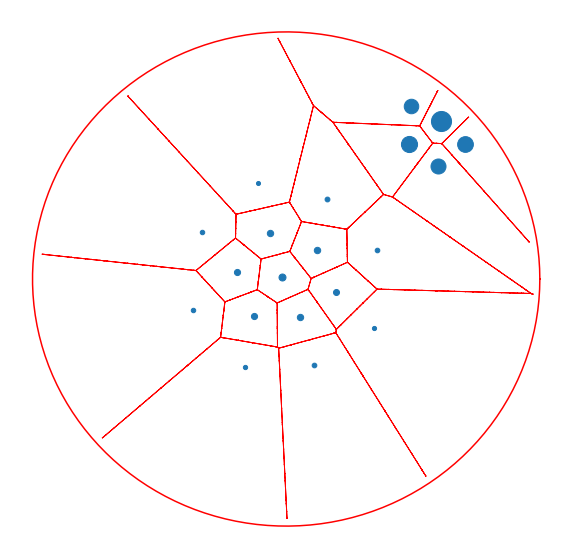

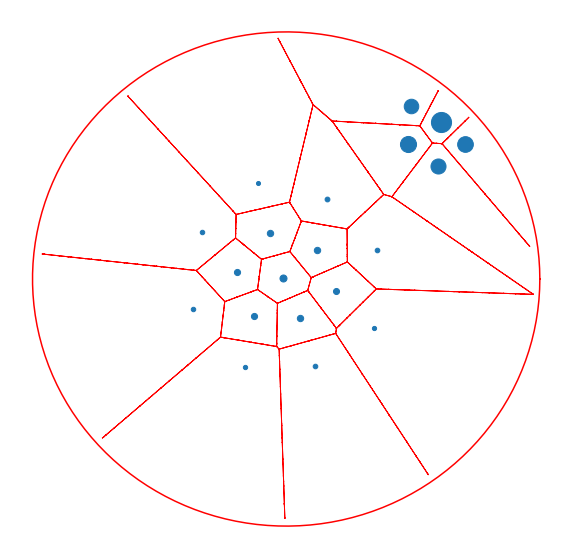

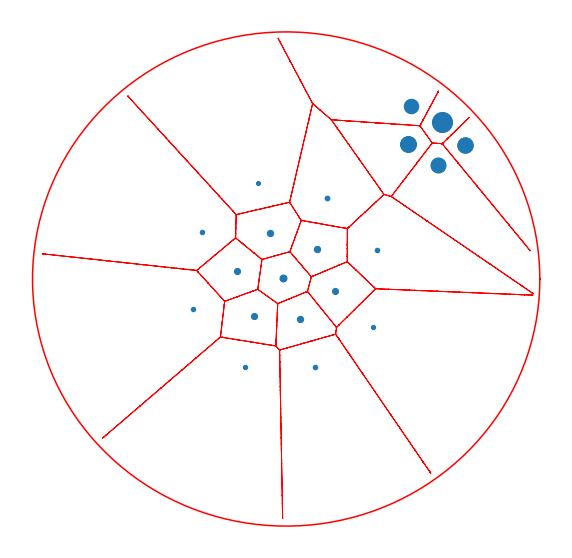

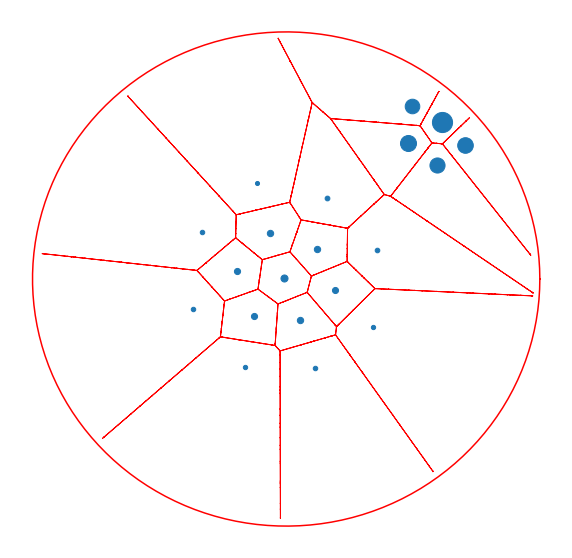

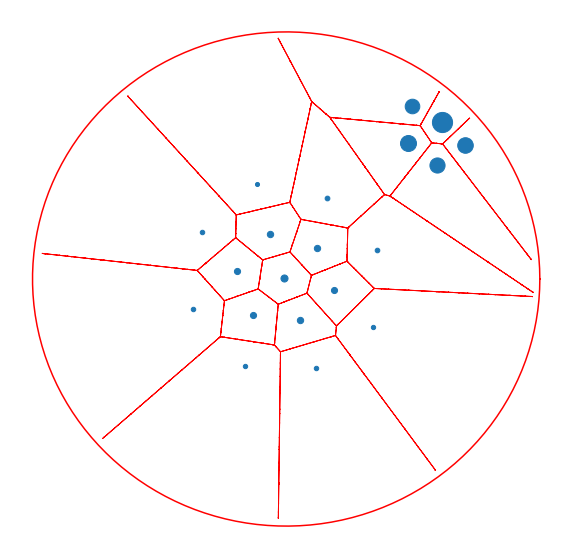

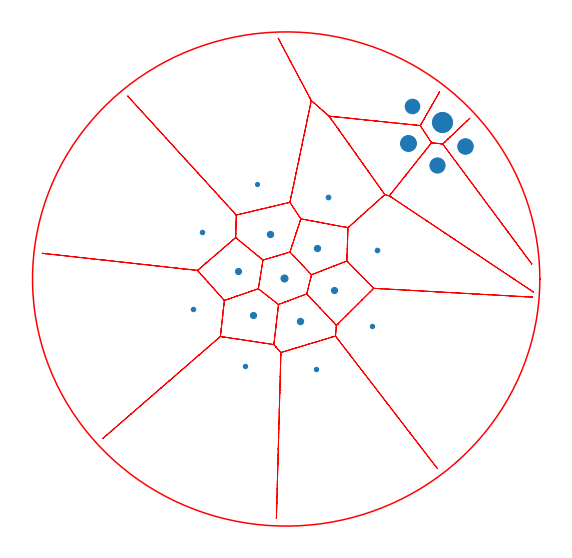

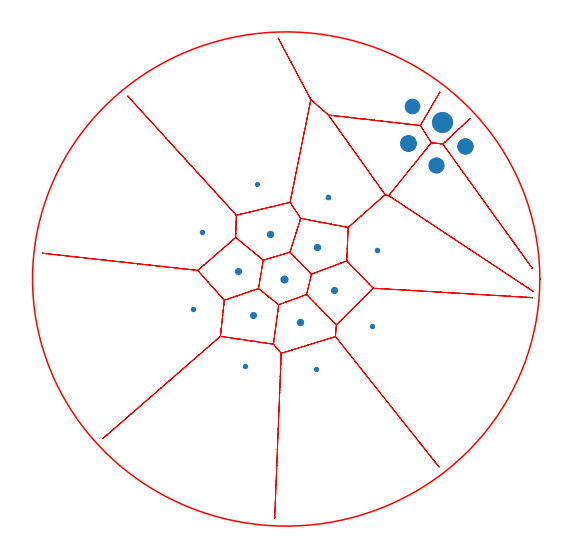

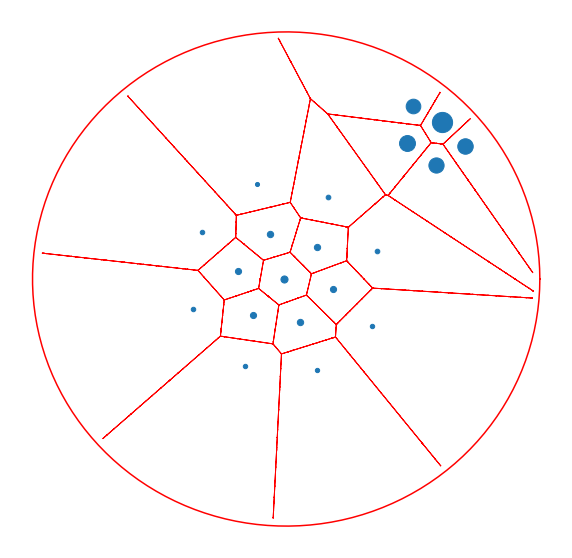

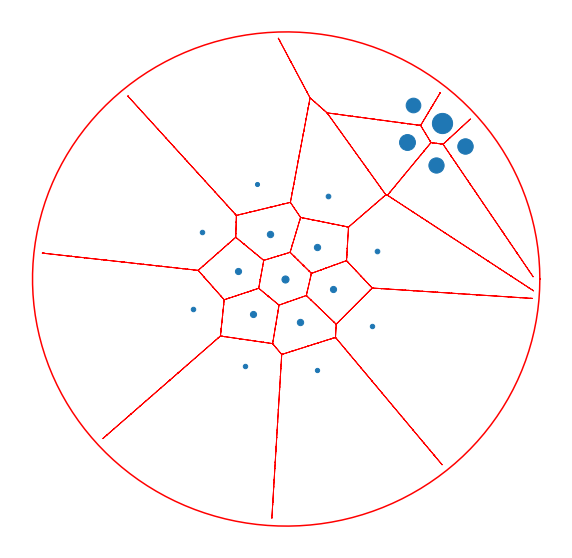

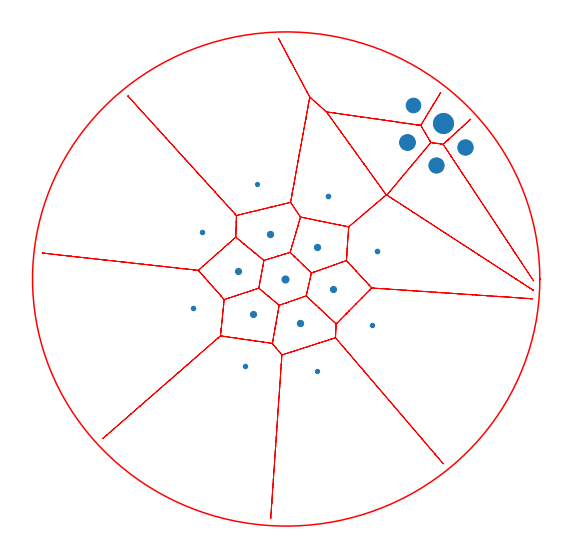

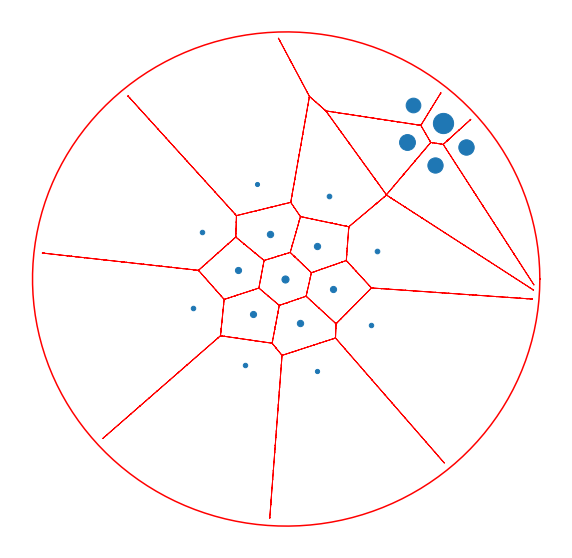

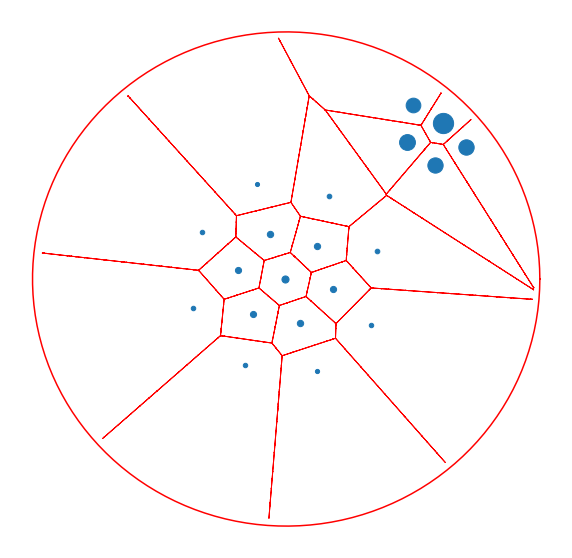

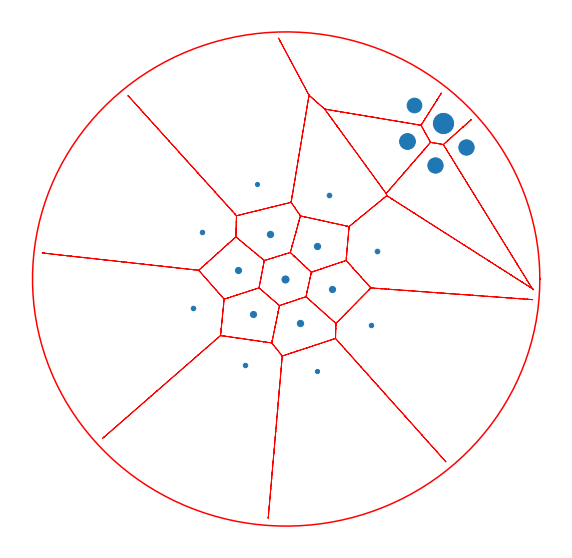

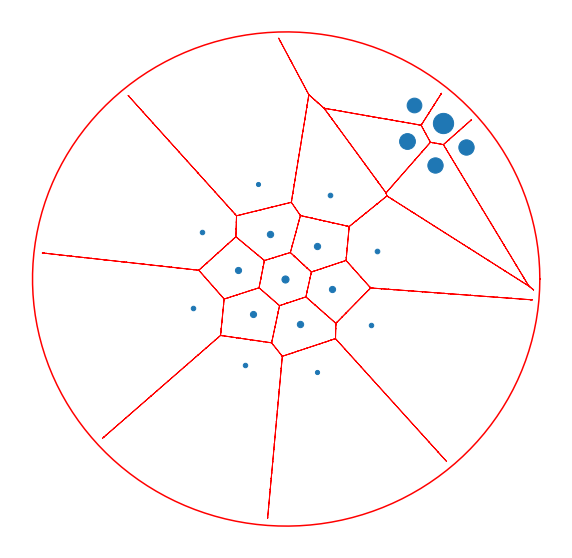

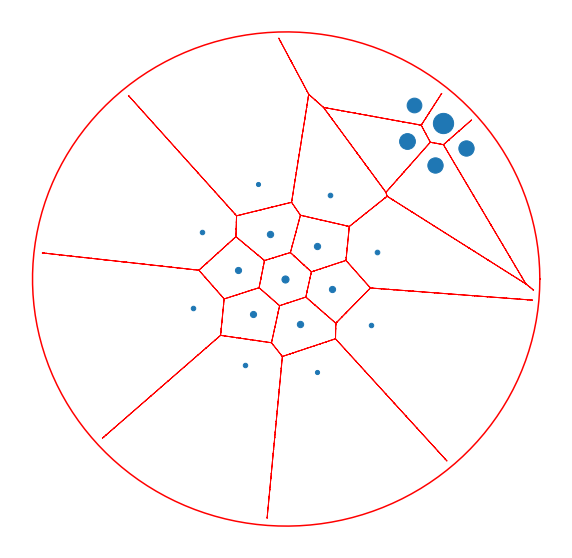

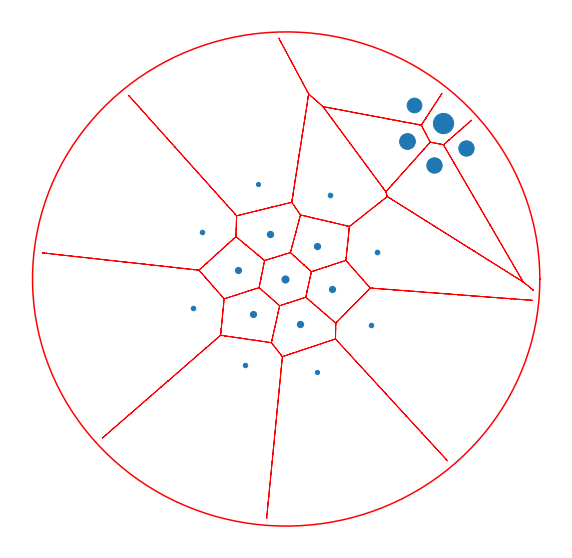

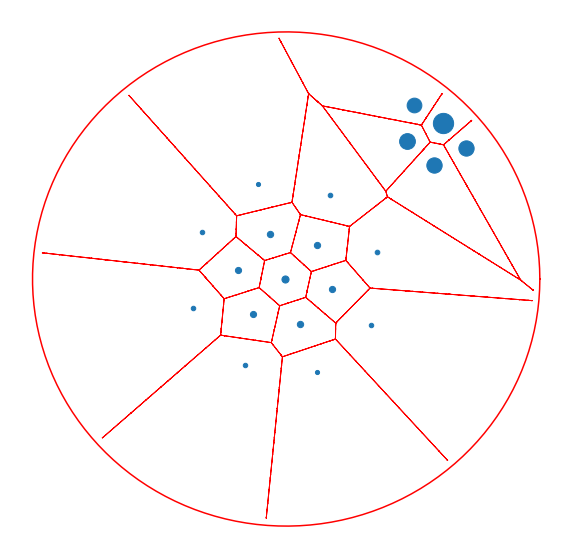

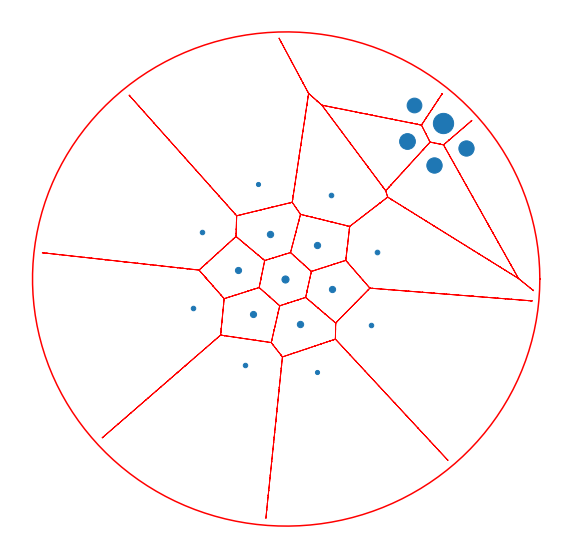

ValueError: too many values to unpack (expected 2)

In [10]:
[Y_opt,m]=Lloyd_iter_draw_Voronoi(dens,Y,100,2.5,True)